In [2]:
import pennylane as qml
import os
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import *

from jax import numpy as jnp
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from qutip import *

 # Using pennylane's wrapped numpy
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint
import jax
import numpy as np
from jax import random
import scipy
import pickle
import base64
import time
import os
import ast
import pandas as pd
from pathlib import Path
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
from functools import partial
from pennylane import numpy as pnp
from jax import config
import optax
from pennylane.transforms import transform
from typing import Sequence, Callable, Union, List
from itertools import chain
from functools import partial, singledispatch

import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from jax import jit
import pennylane as qml
import time
#from pennylane.pulse import ParametrizedEvolution, ParametrizedHamiltonian,HardwareHamiltonian
from jax.experimental.ode import odeint

has_jax = True
diable_jit = False
config.update('jax_disable_jit', diable_jit)
#config.parse_flags_with_absl()
config.update("jax_enable_x64", True)
os.environ['JAX_TRACEBACK_FILTERING'] = 'off'
# global_cache_data = None
# global_processed_files = None


In [3]:
from qfim_store import rebuild_df_from_existing_cache,maybe_rebuild_or_process
base_path = "/Users/sophieblock/QRCcapstone/parameter_analysis_directory/"
model_type = "gate"
N_ctrls = [2,3]
sample_range = "pi"
K_str = "1"
threshold = 1e-10
by_test = False

# 1) Possibly we do:
#    df_all = rebuild_df_from_existing_cache(base_path, N_ctrls, K_str)
#    if df_all.empty, we call process_and_cache_new_files
#    or we do the combined approach:
# df_all = maybe_rebuild_or_process(
#     base_path, sample_range, model_type, N_ctrls, K_str,
#     threshold=threshold, by_test=by_test
# )
df_all = rebuild_df_from_existing_cache(base_path, N_ctrls, K_str)


[INFO] Loaded cache for N_ctrl=2 from disk at /Users/sophieblock/QRCcapstone/parameter_analysis_directory/digital_new_QFIM_Nc_2_1K.pkl.
[INFO] Loaded cache for N_ctrl=3 from disk at /Users/sophieblock/QRCcapstone/parameter_analysis_directory/digital_new_QFIM_Nc_3_1K.pkl.


In [5]:

from qfim_store import rebuild_df_from_existing_cache,compute_spread_columns,to_2d,build_qfim_dataframe
import numpy as np
from scipy.stats import median_abs_deviation

def spread_per_sample_vectorized(
    eigs_2d, method="variance", threshold=1e-12, ddof=1, scale="normal"
):
    """
    For each row in eigs_2d (one 'draw'), threshold small eigenvalues to 0,
    renormalize so they sum to 1, then compute spread of log(eigs).
    Returns a 1D array: one spread value per draw.
    """
    # Clip to zero below threshold
    clipped = np.where(eigs_2d > threshold, eigs_2d, 0.0)
    row_sums = clipped.sum(axis=1, keepdims=True)
    nonzero_mask = (row_sums[:, 0] > 0)
    clipped[nonzero_mask] /= row_sums[nonzero_mask]

    with np.errstate(divide='ignore'):
        logs = np.log(clipped, out=np.zeros_like(clipped), where=(clipped > 0))

    def compute_spread_metric(values, method, ddof, scale):
        if len(values) <= 1:
            return 0.0
        if method == "variance":
            return np.var(values, ddof=ddof)
        elif method == "mad":
            return median_abs_deviation(values, scale=scale)
        else:
            raise ValueError(f"Unknown method: {method}")

    results = []
    # '/Volumes/Block 1/untitled folder'
    for i in range(eigs_2d.shape[0]):
        row_nonzero = logs[i, clipped[i] > 0]
        spread_val = compute_spread_metric(row_nonzero, method, ddof, scale)
        results.append(spread_val)

    return np.array(results)

def spread_pooling_vectorized(
    eigs_2d, method="variance", threshold=1e-12, ddof=1, scale="normal"
):
    """
    Flatten all draws into one big array (above threshold), renormalize,
    compute the spread of log(eigs) for the entire pool.
    """
    flat = eigs_2d.ravel()
    filtered = flat[flat > threshold]
    if filtered.size <= 1:
        return 0.0
    total = filtered.sum()
    filtered /= total

    with np.errstate(divide='ignore'):
        logs = np.log(filtered)

    if method == "variance":
        return np.var(logs, ddof=ddof)
    elif method == "mad":
        return median_abs_deviation(logs, scale=scale)
    else:
        raise ValueError(f"Unknown method: {method}")

def approximate_effective_dimension(
    eigenvalues: np.ndarray,
    n: int,
    gamma: float,
    vol_param_space: float = 1.0
) -> float:
    """
    Approximate the effective dimension d_{gamma,n} by summing log(1 + alpha * lambda_i).
    This is a discrete local version of the formula from
    'The power of quantum neural networks' Section 3.2, ignoring integrals over Theta.

    Parameters
    ----------
    eigenvalues : np.ndarray
        1D array of eigenvalues from a (local) Fisher matrix.
    n : int
        The sample size, used in the factor alpha = gamma*n / (2*log(n)).
    gamma : float
        The hyperparameter in (0,1], controlling how strongly the Fisher enters the dimension.
    vol_param_space : float
        Approximate volume of the parameter space, V_theta. Often set to 1 if unknown.

    Returns
    -------
    d_eff : float
        The approximate effective dimension for these eigenvalues.
    """
    # Avoid log(0) or log negative if n <= 1
    if n <= 1:
        return 0.0

    alpha = gamma * n / (2.0 * np.log(n))

    # sum(log(1 + alpha * lambda_i)) ignoring negative/zero-lambda issues
    inside_sum = 0.0
    for lam in eigenvalues:
        if lam > 0.0:
            inside_sum += np.log(1.0 + alpha * lam)

    # The final formula is: d_eff = -log(V_theta) + sum(...)
    d_eff = -np.log(vol_param_space) + inside_sum
    return d_eff

def effective_dimension_from_paper(
    fisher_eigenvalues: np.ndarray,
    n: int,
    gamma: float,
    V_theta: float
) -> float:
    """
    Compute the effective dimension d_{gamma,n}(M_theta) as in Eq. (2) of the paper:

        d_{gamma,n} = 2 * log( (1/sqrt(V_theta)) * sqrt(det(I_d + alpha * Fhat(theta))) )
                     = - log(V_theta) + log( prod_i (1 + alpha * lambda_i) )

    where alpha = gamma * n / (2 * log(n)) and the product runs over the eigenvalues lambda_i
    of the Fisher matrix.

    Parameters
    ----------
    fisher_eigenvalues : np.ndarray
        1D array of eigenvalues (nonnegative) of the Fisher matrix Fhat(theta).
    n : int
        Number of data samples, used in alpha = gamma*n / (2*log(n)).
    gamma : float
        Constant in (0, 1], controlling how strongly the Fisher enters the dimension.
    V_theta : float
        The volume of the parameter space.  (Set to 1 if unsure.)

    Returns
    -------
    d_eff : float
        The effective dimension from the paper's Eq. (2).
    """
    if n < 2 or np.log(n) <= 0:
        # Edge case: can't compute alpha if n=1 or log(n) <= 0
        return 0.0

    alpha = gamma * n / (2.0 * np.log(n))

    # Avoid negative or complex logs if alpha < 0 or fisher_eigenvalues < 0
    # but these should be nonnegative anyway (Fisher is PSD).
    log_det_term = 0.0
    for lam in fisher_eigenvalues:
        # (1 + alpha * lam)
        log_det_term += np.log1p(alpha * lam) if lam > 0 else 0.0

    # So the core formula from the paper: 
    #    d_eff = - log(V_theta) + sum_i( log(1 + alpha * lam_i) )
    d_eff = - np.log(V_theta) + log_det_term
    return d_eff
def compute_all_stats(
    eigval_list,
    threshold=1e-12,
    spread_methods=("variance", "mad"),  # e.g. ["variance", "mad"]
    ddof=1,
    scale="normal",
    # Additional args for the approximate effective dimension
    do_effective_dim=True,
    vol_param_space=1.0,
    gamma=0.1,    
    n=100,
    V_theta=1.0,
):
    """
    Compute QFIM statistics for a list of draws (eigval_list),
    plus spread-of-log metrics via sample & pooled approaches,
    and an approximate 'effective dimension' from the paper.

    Returns a dict with columns that match your usual naming scheme.
    """

    import numpy as np

    # 1) Basic per-draw computations
    ranks_per_draw = []
    var_all_per_draw = []
    var_nonzero_per_draw = []
    trace_per_draw = []
    var_norm_len_per_draw = []
    var_norm_rank_per_draw = []
    trace_norm_len_per_draw = []
    trace_norm_rank_per_draw = []

    for eigs in eigval_list:
        arr = np.array(eigs, dtype=float)
        arr = np.where(arr < threshold, 0.0, arr)
        rank = np.count_nonzero(arr)
        ranks_per_draw.append(rank)

        var_all = np.var(arr)
        var_all_per_draw.append(var_all)

        nonz = arr[arr > 0]
        var_non = np.var(nonz) if nonz.size > 1 else 0.0
        var_nonzero_per_draw.append(var_non)

        trace_val = arr.sum()
        trace_per_draw.append(trace_val)

        length = len(arr) if len(arr) else 1
        var_norm_len_per_draw.append(var_all / length)
        trace_norm_len_per_draw.append(trace_val / length)

        if rank > 0:
            var_norm_rank_per_draw.append(var_all / rank)
            trace_norm_rank_per_draw.append(trace_val / rank)
        else:
            var_norm_rank_per_draw.append(0.0)
            trace_norm_rank_per_draw.append(0.0)

    # 2) Aggregate across draws
    D_C = max(ranks_per_draw) if ranks_per_draw else 0
    avg_var_all = np.mean(var_all_per_draw) if var_all_per_draw else 0.0
    avg_var_nonzero = np.mean(var_nonzero_per_draw) if var_nonzero_per_draw else 0.0
    avg_trace = np.mean(trace_per_draw) if trace_per_draw else 0.0
    avg_trace_len = np.mean(trace_norm_len_per_draw) if trace_norm_len_per_draw else 0.0
    avg_trace_rank = np.mean(trace_norm_rank_per_draw) if trace_norm_rank_per_draw else 0.0
    avg_var_norm_len = np.mean(var_norm_len_per_draw) if var_norm_len_per_draw else 0.0
    avg_var_norm_rank = np.mean(var_norm_rank_per_draw) if var_norm_rank_per_draw else 0.0

    var_var_all = np.var(var_all_per_draw) if len(var_all_per_draw) > 1 else 0.0
    var_var_nonzero = np.var(var_nonzero_per_draw) if len(var_nonzero_per_draw) > 1 else 0.0

    # 3) Flatten eigenvalues to build a single array for "effective dimension"
    #    We'll do a naive 'pooled' approach:
    all_eigs_concat = np.concatenate([
        np.where(np.array(eigs) < threshold, 0.0, eigs) for eigs in eigval_list
    ]) if eigval_list else np.array([])
    # 4) Effective Dimension from Eq. (2) in the paper
    #    d_{gamma,n} = 2 ln( (1/sqrt(V_theta)) * sqrt( det( I + alpha F ) ) )
    #                = -ln(V_theta) + sum_i( ln(1 + alpha lambda_i) )
    #    alpha = gamma * n / (2 ln(n))
    # If you want to do a "global" integral, you'd loop over param points or do MCMC.
    eff_dim_val = 0.0
    if do_effective_dim and all_eigs_concat.size > 0:
        eff_dim_val = effective_dimension_from_paper(
            fisher_eigenvalues=all_eigs_concat,
            n=n, gamma=gamma, V_theta=V_theta
        )
    effective_dim_value = 0.0
    if do_effective_dim and all_eigs_concat.size > 0:
        effective_dim_value = approximate_effective_dimension(
            all_eigs_concat, n=n, gamma=gamma, vol_param_space=vol_param_space
        )

    # 4) Spread-of-log metrics for each method in spread_methods
    #    We'll build arr_2d to use your existing vectorized functions.
    arr_2d = np.zeros((len(eigval_list), max(len(x) for x in eigval_list))) if eigval_list else np.zeros((0,0))
    for i, e in enumerate(eigval_list):
        tmp = np.array(e, dtype=float)
        tmp = np.where(tmp < threshold, 0.0, tmp)
        arr_2d[i, :len(tmp)] = tmp

    spread_results = {}
    from functools import partial

    # We'll rely on your existing spread_per_sample_vectorized & spread_pooling_vectorized:
    # e.g. spread_per_sample_vectorized(arr_2d, method="variance", threshold=1e-12, ddof=1, scale="normal")
    for method in spread_methods:
        per_draw = spread_per_sample_vectorized(
            arr_2d, method=method, threshold=threshold, ddof=ddof, scale=scale
        )
        spread_mean = per_draw.mean() if per_draw.size else 0.0
        spread_std  = per_draw.std()  if per_draw.size > 1 else 0.0

        pooled_val = spread_pooling_vectorized(
            arr_2d, method=method, threshold=threshold, ddof=ddof, scale=scale
        )

        # Store them with keys that include the scale
        prefix = method.lower()
        # e.g. "spread_mean_per_sample_mad_normal"
        spread_results[f"spread_mean_per_sample_{prefix}_{scale}"] = spread_mean
        spread_results[f"spread_std_per_sample_{prefix}_{scale}"]  = spread_std
        spread_results[f"spread_val_pooled_{prefix}_{scale}"]      = pooled_val

    # 5) Final dictionary
    metrics = {
        # Per-draw lists
        "QFIM_ranks": ranks_per_draw,
        "test_var_qfim_eigvals": var_all_per_draw,
        "test_var_qfim_eigvals_nonzero": var_nonzero_per_draw,
        "test_tr_qfim_eigvals": trace_per_draw,
        "test_var_qfim_eigvals_normalized": var_norm_len_per_draw,
        "test_var_qfim_eigvals_normalized_by_rank": var_norm_rank_per_draw,

        # Aggregated
        "D_C": D_C,
        "avg_test_var_qfim_eigvals": avg_var_all,
        "avg_test_var_qfim_eigvals_nonzero": avg_var_nonzero,
        "avg_test_tr_qfim_eigvals": avg_trace,
        "avg_test_tr_qfim_eigvals_norm": avg_trace_len,
        "avg_test_tr_qfim_eigvals_norm_by_rank": avg_trace_rank,
        "avg_test_var_qfim_eigvals_normalized": avg_var_norm_len,
        "avg_test_var_qfim_eigvals_normalized_by_rank": avg_var_norm_rank,
        "var_test_var_qfim_eigvals": var_var_all,
        "var_test_var_qfim_eigvals_nonzero": var_var_nonzero,

        # Approx. effective dimension
        "effective_dimension": effective_dim_value,
        "effective_dimensio2": eff_dim_val,
    }

    # Merge in the spread-of-log results with the new naming
    metrics.update(spread_results)

    return metrics

def build_qfim_dataframe(df_all, threshold=1e-12):
    """
    1) Convert all_qfim_eigvals -> qfim_eigs_2d
    2) Single-pass stats => expanded columns (including spread-of-log)
    3) Optionally, extra 'compute_spread_columns' calls 
       if you want separate columns for 'median', etc.
    4) Return final df_all with everything included.
    """
    # 1) Convert for convenience
    df_all["qfim_eigs_2d"] = df_all["all_qfim_eigvals"].apply(to_2d)

    # 2) Single-pass stats
    stats_series = df_all["all_qfim_eigvals"].apply(
        lambda x: compute_all_stats(
            x, 
            threshold=threshold, 
            spread_methods=["variance", "mad"], # you can add 'median' if you like
            ddof=1, 
            scale="normal"
        )
    )
    df_stats = pd.json_normalize(stats_series)
    df_out = pd.concat([df_all.reset_index(drop=True), df_stats.reset_index(drop=True)], axis=1)

    # 3) If you still want “extra” spread columns for e.g. 'median' or other transformations,
    #    you can also call your existing compute_spread_columns(...) here:
    # df_out = compute_spread_columns(df_out, threshold=threshold, spread_method="median", scale="normal")
    # etc.

    return df_out
print("[INFO] df_all shape after reading cache or scanning directories:", df_all.shape)
# 2) Build QFIM DataFrame with advanced metrics
df_all = build_qfim_dataframe(df_all, threshold=1e-12)
print("[INFO] df_all final shape:", df_all.shape)


[INFO] df_all shape after reading cache or scanning directories: (414, 5)
[INFO] df_all final shape: (414, 30)


In [7]:
df_all = compute_spread_columns(df_all, threshold=threshold, spread_method="mad", scale="normal")
df_all.keys()

Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'mean_entropy', 'qfim_eigs_2d', 'QFIM_ranks', 'test_var_qfim_eigvals',
       'test_var_qfim_eigvals_nonzero', 'test_tr_qfim_eigvals',
       'test_var_qfim_eigvals_normalized',
       'test_var_qfim_eigvals_normalized_by_rank', 'D_C',
       'avg_test_var_qfim_eigvals', 'avg_test_var_qfim_eigvals_nonzero',
       'avg_test_tr_qfim_eigvals', 'avg_test_tr_qfim_eigvals_norm',
       'avg_test_tr_qfim_eigvals_norm_by_rank',
       'avg_test_var_qfim_eigvals_normalized',
       'avg_test_var_qfim_eigvals_normalized_by_rank',
       'var_test_var_qfim_eigvals', 'var_test_var_qfim_eigvals_nonzero',
       'effective_dimension', 'effective_dimensio2',
       'spread_mean_per_sample_variance_normal',
       'spread_std_per_sample_variance_normal',
       'spread_val_pooled_variance_normal',
       'spread_mean_per_sample_mad_normal', 'spread_std_per_sample_mad_normal',
       'spread_val_pooled_mad_normal', 'spread_mean_pe

In [ ]:
def add_deff_ipr(df, threshold=1e-12, qfim_col="all_qfim_eigvals", out_col="d_eff_ipr"):
    """
    Adds a new column to 'df' with the approximate effective dimension
    d_eff^(IPR) = ( sum_i λ_i )^2 / ( sum_i λ_i^2 ), 
    where λ_i are all QFIM eigenvalues (pooled across draws) for that row.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain a column 'qfim_col' holding a list of eigenvalue arrays.
        Typically, this is "all_qfim_eigvals" from your pipeline.
    threshold : float
        Eigenvalues below this are set to zero before computing the ratio.
    qfim_col : str
        The column name that holds your list of draws' eigenvalues for each row.
    out_col : str
        The name of the new column to store d_eff^(IPR).
    
    Returns
    -------
    df : pd.DataFrame
        The same dataframe, but with a new column 'out_col' containing
        the d_eff^(IPR) value for each row.
    """
    # For each row, pool all draws' eigenvalues, apply threshold, then compute ratio
    for idx, row in df.iterrows():
        all_draws = row[qfim_col]  # This should be a list of 1D arrays
        if not isinstance(all_draws, (list, tuple)) or len(all_draws) == 0:
            df.loc[idx, out_col] = 0.0
            continue

        # Concatenate all draws into one array
        pooled_eigs = np.concatenate([
            np.where(np.array(e) < threshold, 0.0, e) 
            for e in all_draws
        ])

        # Inverse participation ratio formula:
        sum_eigs = pooled_eigs.sum()
        sum_eigs_sq = np.sum(pooled_eigs ** 2)

        if sum_eigs_sq > 0:
            d_eff_ipr = (sum_eigs ** 2) / sum_eigs_sq
        else:
            d_eff_ipr = 0.0

        df.loc[idx, out_col] = d_eff_ipr

    return df
df_all = add_deff_ipr(df_all, threshold=1e-12, qfim_col="all_qfim_eigvals", out_col="d_eff_ipr")

Detected critical T_C = 6
[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 6


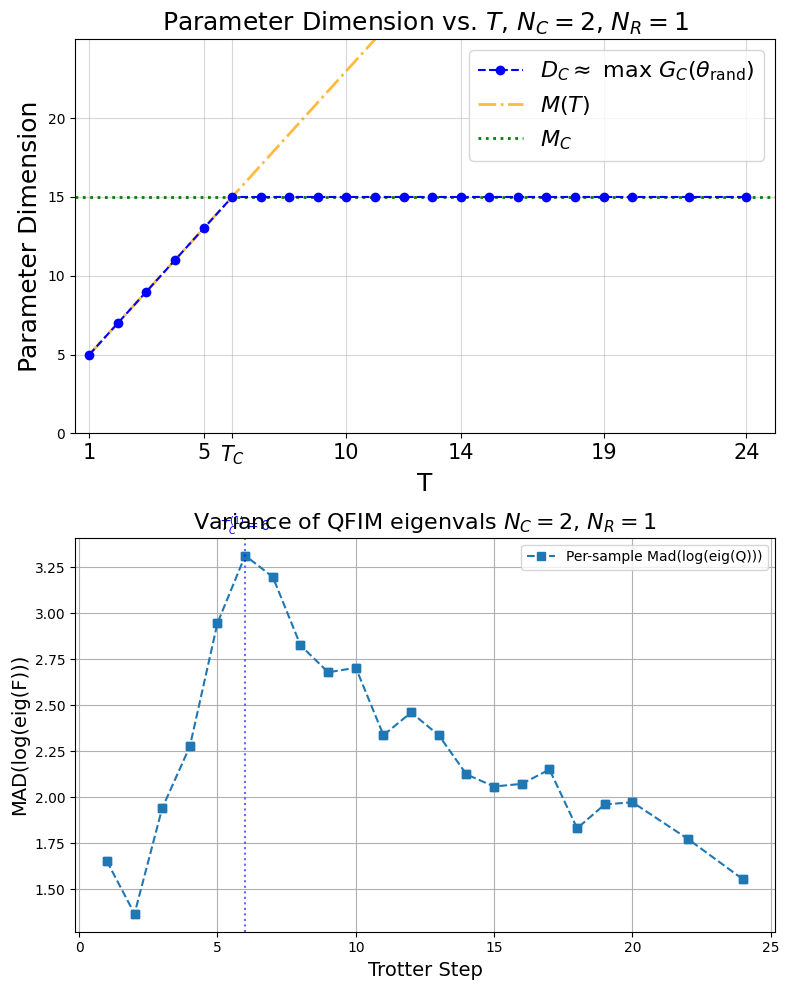

In [36]:
def plot_spread_analysis(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                         spread_type="variance", combination="pooled",
                         show_yerr=False, title=None, xlabel="Trotter Step",
                         ylabel=None, num_ticks=6, scale='normal'):
    """
    Plots the spread analysis based on the given spread type and combination technique,
    *with* an annotated T_C vertical line (T_C^{(N_R)}).
    
    Parameters:
    -----------
    - df: DataFrame containing spread data.
    - chosen_n_ctrl: Selected N_ctrl value.
    - chosen_n_reserv: Selected N_reserv value.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - spread_type: 'variance' or 'mad'.
    - combination: 'pooled' or 'sampled'.
    - show_yerr: Whether to plot error bars (for sample-based only).
    - title: Title of the plot.
    - xlabel, ylabel: Axis labels.
    - num_ticks: number of x-ticks to generate.
    - scale: 'normal', etc., to match your naming in df columns.
    """

    # Ensure valid inputs
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")
    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be 'pooled' or 'sampled'")

    # Filter data for the chosen N_ctrl, N_reserv
    df_plot = df.query("N_ctrl==@chosen_n_ctrl & N_reserv==@chosen_n_reserv").copy()
    df_plot.sort_values("Trotter_Step", inplace=True)

    # Extract x values
    x_vals = df_plot["Trotter_Step"].values

    # Column names for y-values
    y_mean_key = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_std_key  = f"spread_std_per_sample_{spread_type}_{scale}"
    y_pool_key = f"spread_val_pooled_{spread_type}_{scale}"

    y_mean, y_std, y_pool = (
        df_plot[y_mean_key].values,
        df_plot[y_std_key].values,
        df_plot[y_pool_key].values
    )

    # Decide which array to use for peak detection & plotting
    if combination == "sampled":
        data_for_peak = y_mean
        data_label = f"Per-sample {spread_type.capitalize()}(log(eig(Q)))"
    else:  # "pooled"
        data_for_peak = y_pool
        data_label = f"Pooled {spread_type.capitalize()}(log(eig(Q)))"

    # Identify peak (T_C)
    peak_idx = int(np.argmax(data_for_peak))
    peak_T   = x_vals[peak_idx]
    peak_val = data_for_peak[peak_idx]
    print(f"[INFO] For N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv}, "
          f"peak T_C is {peak_T}")

    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Actually plot
    if combination == "sampled":
        if show_yerr:
            ax.errorbar(
                x_vals, y_mean, yerr=y_std, fmt="o--",
                capsize=4, label=f"{data_label} ± std"
            )
        else:
            ax.plot(
                x_vals, y_mean, "s--", label=data_label
            )
    else:  # combination == "pooled"
        ax.plot(x_vals, y_pool, "s--", label=data_label)

    # Construct x-ticks, ensuring T=1 and T_C are included
    # x_ticks = np.linspace(min(x_vals), max(x_vals), num=num_ticks, dtype=int)
    # x_ticks = np.unique(np.append(x_ticks, [1, peak_T]))  # ensure T=1 & T_C

    # # Label T_C explicitly on x-axis
    # xtick_labels = [f"$T_C$" if tick == peak_T else str(tick) for tick in x_ticks]
    # ax.set_xticks(x_ticks)
    # ax.set_xticklabels(xtick_labels, fontsize=15)

    # 2) Annotate T_C with a vertical line plus a text label T_C^{(N_reserv)}
    ax.axvline(x=peak_T, color='b', linestyle=':', alpha=0.6)
    ax.text(
        peak_T, peak_val + 0.1,
        fr"$T_C^{{({chosen_n_reserv})}}={peak_T}$",
        fontsize=10, color='b',
        ha='center', va='bottom'
    )

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)
    if not title:
        title=f'Variance of QFIM eigenvals $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    ax.set_title(title or f"{spread_type.capitalize()}-based Spread Analysis", fontsize=16)
    ax.grid(True)
    ax.legend()

    return ax

def get_num_params(N_r, N_c, T, model_type = 'digital'):
        if model_type == 'analog':
            return N_r * N_c * T + 3 + T
        elif model_type == 'digital':
            return N_r * N_c * T + 3
        else:
             raise TypeError(f'No model type: {model_type}')
def plot_max_rank_vs_params(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                            xlabel='T', ylabel='Parameter Dimension', title=None,
                            color='b', param_color='orange', critical_color='green',
                            legend_loc='upper right',num_ticks=6):
    """
    Plots max rank vs. parameters for given control and reservoir values.

    Parameters:
    - df: DataFrame containing 'Trotter_Step', 'N_ctrl', 'N_reserv', 'QFIM_ranks'.
    - chosen_n_ctrl: Selected control value for filtering.
    - chosen_n_reserv: Selected reservoir value for filtering.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - xlabel, ylabel: Axis labels.
    - title: Title of the plot.
    - color: Color for max rank plot line.
    - param_color: Color for parameter dimension line.
    - critical_color: Color for the critical threshold line.
    - legend_loc: Legend location.
    """
    
    # Filter for chosen values
    subset = df[(df['N_ctrl'] == chosen_n_ctrl) & (df['N_reserv'] == chosen_n_reserv)]
    
    trotter_steps, max_ranks = [], []
    for T_step, grp in subset.groupby('Trotter_Step'):
        all_ranks = [rank for row in grp['QFIM_ranks'] for rank in row]
        max_rank = np.max(all_ranks) if all_ranks else 0
        trotter_steps.append(T_step)
        max_ranks.append(max_rank)

    # Sort data
    trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

    # Compute parameter dimension M(T)
    param_list = [get_num_params(chosen_n_reserv, chosen_n_ctrl, t) for t in trotter_steps]

    # Detect critical T_C
    idx_C = int(np.argmax(max_ranks))
    T_C, M_C = trotter_steps[idx_C], param_list[idx_C]
    print(f"Detected critical T_C = {T_C}")
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot max rank vs. Trotter step
    ax.plot(trotter_steps, max_ranks, marker='o', linestyle='--', color=color,
            label=r'$D_C \approx$ max $G_C(\theta_{\text{rand}})$', zorder=10)
    
    # Plot M(T)
    ax.plot(trotter_steps, param_list, color=param_color, linestyle='-.',
            alpha=0.75, linewidth=2, label='$M(T)$')
    
    # Horizontal line at M_C
    ax.axhline(y=M_C, color=critical_color, linestyle=':', linewidth=2, label='$M_C$')

    # X-axis ticks: evenly spaced, always including T=1 and T_C
    x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1, T_C]))  # Ensure T=1 and T_C are always included

    # Labeling T_C explicitly
    xtick_labels = [f"$T_C$" if tick == T_C else str(tick) for tick in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(xtick_labels, fontsize=15)
    


    # Y-axis: Ensure labels are integers
    ax.set_yticks(np.arange(0, max(max_ranks) + 10, step=5))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.legend(fontsize=16, loc=legend_loc)
    ax.grid(True, alpha=0.5)
    ax.set_ylim(top=M_C + 10)
    ax.set_xlim(left=0.5, right=max(trotter_steps)+1)
    if not title:
        title=f'Parameter Dimension vs. $T$, $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    if title:
        ax.set_title(title, fontsize=18)

    return ax
chosen_n_reserv = 1
chosen_n_ctrl = 2
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
plot_max_rank_vs_params(df_all, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, ax=axes[0])
plot_spread_analysis(df_all, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="mad", combination="sampled", ax=axes[1])

plt.tight_layout()
plt.show()

Detected critical T_C = 6
[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 6
Detected critical T_C = 3
[INFO] For N_ctrl=2, N_reserv=2, peak T_C is 3
Detected critical T_C = 2
[INFO] For N_ctrl=2, N_reserv=3, peak T_C is 2


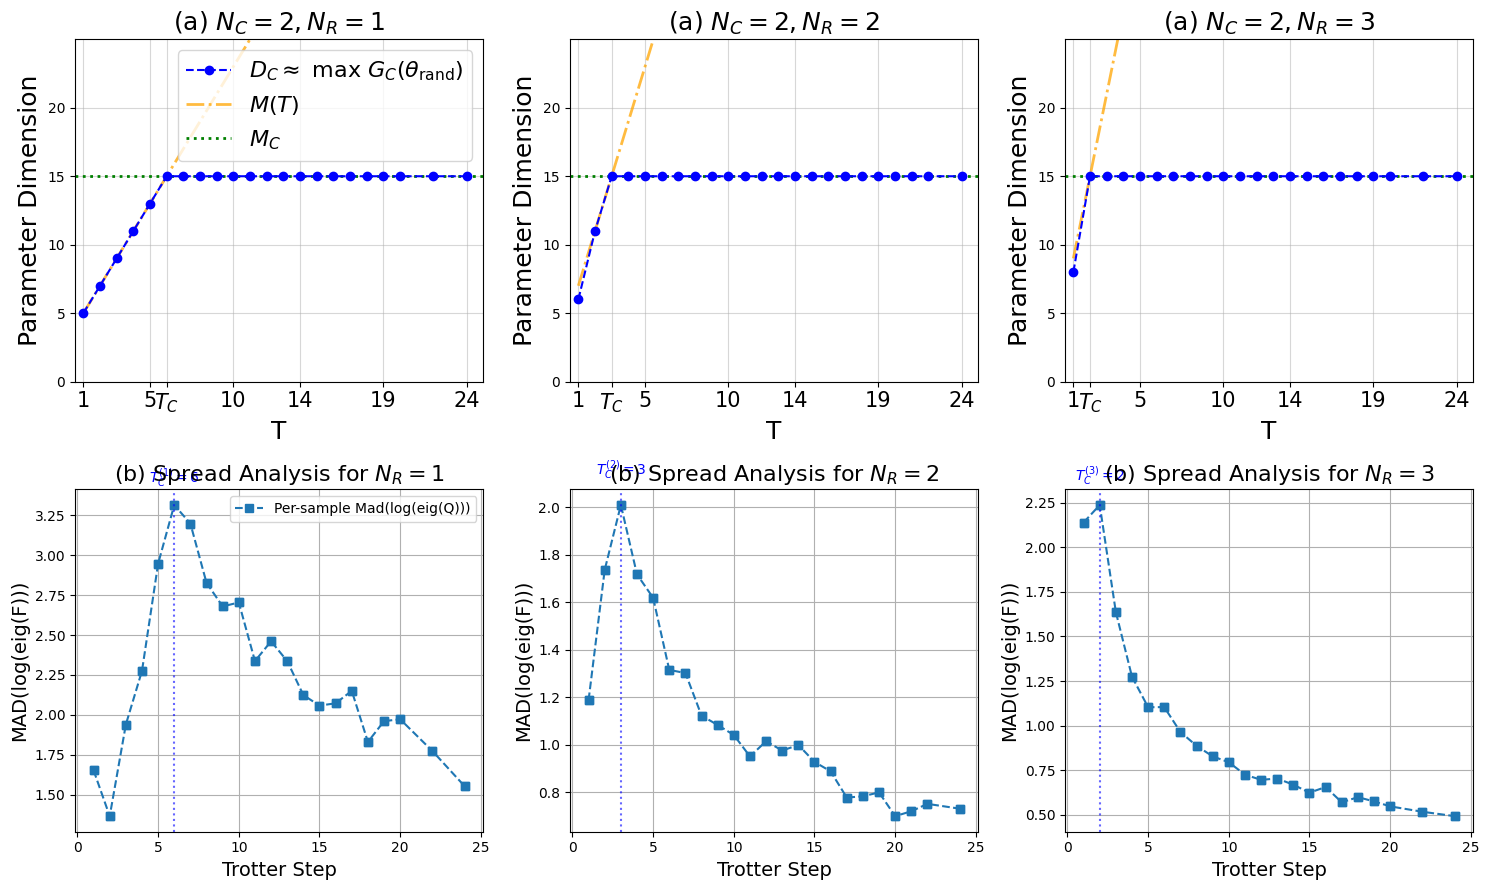

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_many_reserv(df, N_ctrl=2, reserv_list=[1, 2, 3], spread_type="mad"):
    """
    Creates a 2xN grid of subplots, with the top row showing plot_max_rank_vs_params
    and the bottom row showing plot_spread_analysis, each column for a different N_R.

    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing your QFIM info (with 'N_ctrl','N_reserv','Trotter_Step', etc.).
    N_ctrl : int
        The control qubit count to fix for all columns.
    reserv_list : list of int
        The distinct N_reserv values you want to show (e.g. [1, 2, 3]).
    spread_type : str
        'variance' or 'mad', as accepted by your plot_spread_analysis function.

    Returns:
    --------
    fig, axes : The figure and axes objects for further customization.
    """

    # Number of columns is the length of reserv_list
    ncols = len(reserv_list)
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(5*ncols, 9), sharex=False, sharey=False)

    # If there is only 1 column, make sure we index axes as 2D
    if ncols == 1:
        # shape would be (2, ) if there's only one column
        axes = np.array([axes]).T  # transform to shape (2,1)

    for col_idx, nr_val in enumerate(reserv_list):
        # ------------------
        # Top row: max-rank vs. T
        # ------------------
        ax_top = axes[0, col_idx]
        plot_max_rank_vs_params(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val, ax=ax_top,
            xlabel="T", ylabel="Parameter Dimension",
            title=f"(a) $N_C={N_ctrl}, N_R={nr_val}$"
        )

        # Hide repeated legends if you only want them once:
        if col_idx > 0:
            ax_top.legend_.remove()

        # ------------------
        # Bottom row: spread analysis
        # ------------------
        ax_bot = axes[1, col_idx]
        plot_spread_analysis(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val,
            ax=ax_bot, spread_type=spread_type, combination="sampled",
            xlabel="Trotter Step", ylabel=f"{spread_type.upper()}(log(eig(F)))",
            title=f"(b) Spread Analysis for $N_R={nr_val}$"
        )

        if col_idx > 0:
            # Similarly remove legends if you want minimal duplication
            # Or keep them if you prefer each subplot to have its own
            ax_bot.legend_.remove()

    plt.tight_layout()
    return fig, axes

# Example usage:
fig, axes = plot_many_reserv(df_all, N_ctrl=2, reserv_list=[1,2,3], spread_type="mad")
# plt.show()

Detected critical T_C = 6
[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 6
yticks: 2.375
Detected critical T_C = 20
[INFO] For N_ctrl=3, N_reserv=1, peak T_C is 18
yticks: 5.0


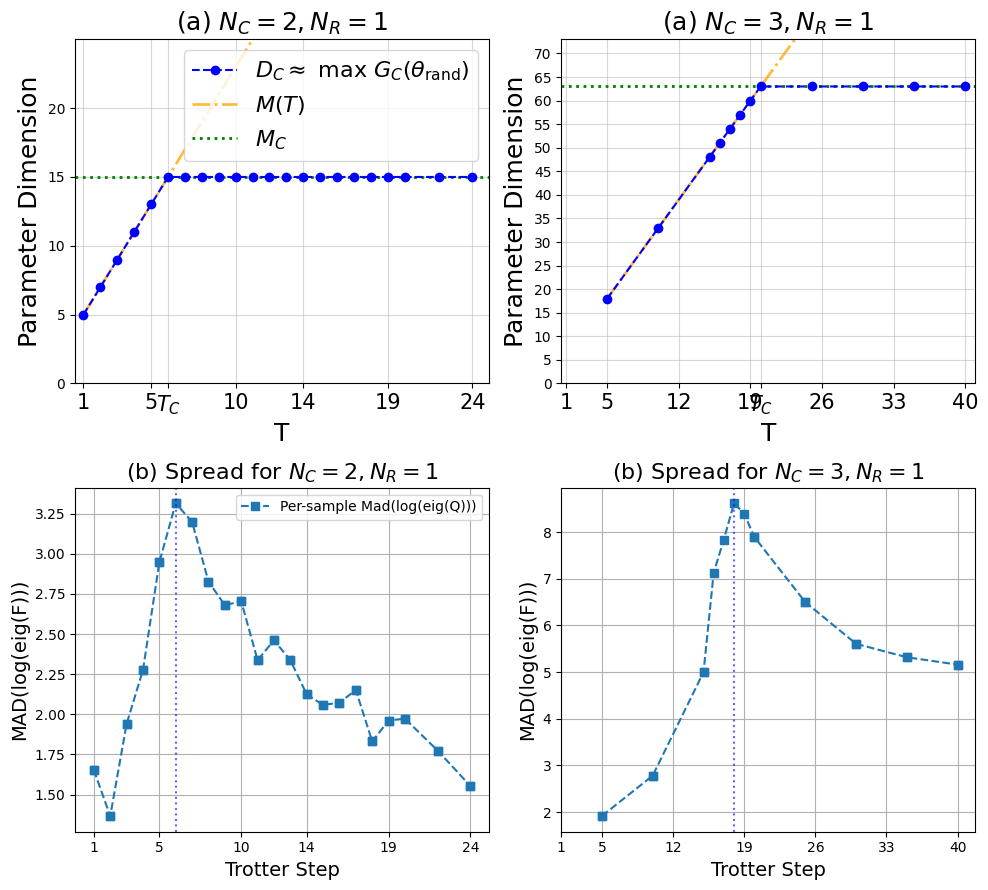

In [55]:
import numpy as np
import matplotlib.pyplot as plt
def plot_spread_analysis_Nc(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                         spread_type="variance", combination="pooled",
                         show_yerr=False, title=None, xlabel="Trotter Step",
                         ylabel=None, num_ticks=6, scale='normal'):
    """
    Plots the spread analysis based on the given spread type and combination technique,
    *with* an annotated T_C vertical line (T_C^{(N_R)}).
    
    Parameters:
    -----------
    - df: DataFrame containing spread data.
    - chosen_n_ctrl: Selected N_ctrl value.
    - chosen_n_reserv: Selected N_reserv value.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - spread_type: 'variance' or 'mad'.
    - combination: 'pooled' or 'sampled'.
    - show_yerr: Whether to plot error bars (for sample-based only).
    - title: Title of the plot.
    - xlabel, ylabel: Axis labels.
    - num_ticks: number of x-ticks to generate.
    - scale: 'normal', etc., to match your naming in df columns.
    """

    # Ensure valid inputs
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")
    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be 'pooled' or 'sampled'")

    # Filter data for the chosen N_ctrl, N_reserv
    df_plot = df.query("N_ctrl==@chosen_n_ctrl & N_reserv==@chosen_n_reserv").copy()
    df_plot.sort_values("Trotter_Step", inplace=True)

    # Extract x values
    x_vals = df_plot["Trotter_Step"].values

    # Column names for y-values
    y_mean_key = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_std_key  = f"spread_std_per_sample_{spread_type}_{scale}"
    y_pool_key = f"spread_val_pooled_{spread_type}_{scale}"

    y_mean, y_std, y_pool = (
        df_plot[y_mean_key].values,
        df_plot[y_std_key].values,
        df_plot[y_pool_key].values
    )

    # Decide which array to use for peak detection & plotting
    if combination == "sampled":
        data_for_peak = y_mean
        data_label = f"Per-sample {spread_type.capitalize()}(log(eig(Q)))"
    else:  # "pooled"
        data_for_peak = y_pool
        data_label = f"Pooled {spread_type.capitalize()}(log(eig(Q)))"

    # Identify peak (T_C)
    peak_idx = int(np.argmax(data_for_peak))
    peak_T   = x_vals[peak_idx]
    peak_val = data_for_peak[peak_idx]
    print(f"[INFO] For N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv}, "
          f"peak T_C is {peak_T}")

    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Actually plot
    if combination == "sampled":
        if show_yerr:
            ax.errorbar(
                x_vals, y_mean, yerr=y_std, fmt="o--",
                capsize=4, label=f"{data_label} ± std"
            )
        else:
            ax.plot(
                x_vals, y_mean, "s--", label=data_label
            )
    else:  # combination == "pooled"
        ax.plot(x_vals, y_pool, "s--", label=data_label)


    x_ticks = np.linspace(min(x_vals), max(x_vals), num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1]))  # Ensure T=1 and T_C are always included

    
    ax.set_xticks(x_ticks)
    
    
    # 2) Annotate T_C with a vertical line plus a text label T_C^{(N_reserv)}
    ax.axvline(x=peak_T, color='b', linestyle=':', alpha=0.6)
    ymin, ymax = ax.get_ylim()
    yticks = ax.get_yticks()
    xticks = ax.get_xticks()
    print(f"yticks: {np.median(yticks)}")

    # ax.text(
    #     peak_T+(xticks[1]-xticks[0]), np.median(yticks),
    #     fr"$T_C^{{({chosen_n_reserv})}}={peak_T}$",
    #     fontsize=10, color='b',
    #     ha='center', va='bottom'
    # )
    # ax.annotate(
    #     fr"$T_C^{{({chosen_n_reserv})}}={peak_T}$",
    #     xy=(peak_T, peak_val),
    #     xytext=(peak_T + 0.5, peak_val + 0.2),
    #     arrowprops=dict(arrowstyle="->", color='b'),
    #     fontsize=10, color='b',
    #     ha='left', va='bottom'
    # )


    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)
    if not title:
        title=f'Variance of QFIM eigenvals $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    ax.set_title(title or f"{spread_type.capitalize()}-based Spread Analysis", fontsize=16)
    ax.grid(True)
    ax.legend()

    return ax
def plot_many_ctrl(df, reserv_fixed=1, ctrl_list=[1,2,3], spread_type="mad"):
    """
    Creates a 2x(len(ctrl_list)) grid of subplots.
      - Top row: plot_max_rank_vs_params for each chosen_n_ctrl in ctrl_list,
                 with chosen_n_reserv = reserv_fixed.
      - Bottom row: plot_spread_analysis for each chosen_n_ctrl.
    
    This is analogous to plot_many_reserv, except we now fix N_reserv and vary N_ctrl.

    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing your QFIM info (with columns 'N_ctrl','N_reserv','Trotter_Step', etc.).
    reserv_fixed : int
        The reservoir-qubit count to fix for all columns (defaults to 1).
    ctrl_list : list of int
        The distinct N_ctrl values you want to show (e.g. [1, 2, 3]).
    spread_type : str
        'variance' or 'mad', to pass into plot_spread_analysis.

    Returns:
    --------
    fig, axes : The figure and axes objects for further customization.
    """

    ncols = len(ctrl_list)
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(5*ncols, 9),
                             sharex=False, sharey=False)
    # If there's only 1 column, ensure axes is 2D
    if ncols == 1:
        axes = np.array([axes]).T  # shape => (2,1)

    for col_idx, ctrl_val in enumerate(ctrl_list):
        # 1) Top row => max rank vs params
        ax_top = axes[0, col_idx]
        plot_max_rank_vs_params(
            df, chosen_n_ctrl=ctrl_val, chosen_n_reserv=reserv_fixed,
            ax=ax_top, xlabel="T", ylabel="Parameter Dimension",
            title=f"(a) $N_C={ctrl_val}, N_R={reserv_fixed}$"
        )
        # Possibly remove legends for columns > 0
        if col_idx > 0 and ax_top.get_legend():
            ax_top.get_legend().remove()

        # 2) Bottom row => spread analysis
        ax_bot = axes[1, col_idx]
        plot_spread_analysis_Nc(
            df, chosen_n_ctrl=ctrl_val, chosen_n_reserv=reserv_fixed,
            ax=ax_bot, spread_type=spread_type, combination="sampled",
            xlabel="Trotter Step", ylabel=f"{spread_type.upper()}(log(eig(F)))",
            title=f"(b) Spread for $N_C={ctrl_val}, N_R={reserv_fixed}$"
        )
        if col_idx > 0 and ax_bot.get_legend():
            ax_bot.legend_.remove()

    plt.tight_layout()
    return fig, axes

# Example usage:

fig, axes = plot_many_ctrl(df_all, reserv_fixed=1, ctrl_list=[2,3], spread_type="mad")
plt.show()


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_20039/1206924581.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_cycle = plt.cm.get_cmap('Set1', len(ctrl_list))


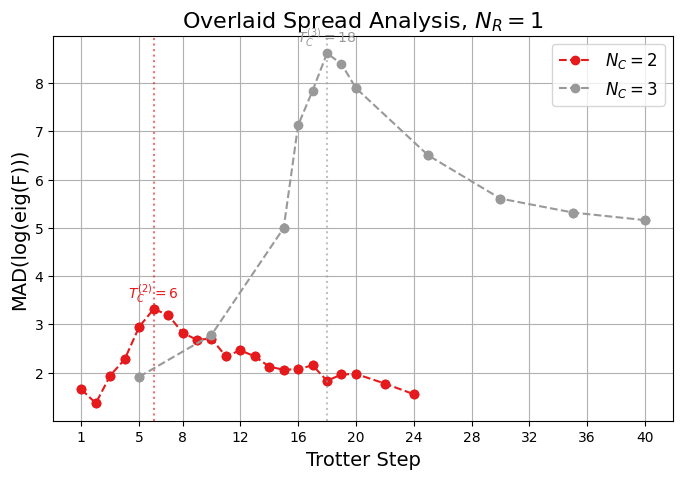

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_20039/1206924581.py:211: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(ctrl_list))


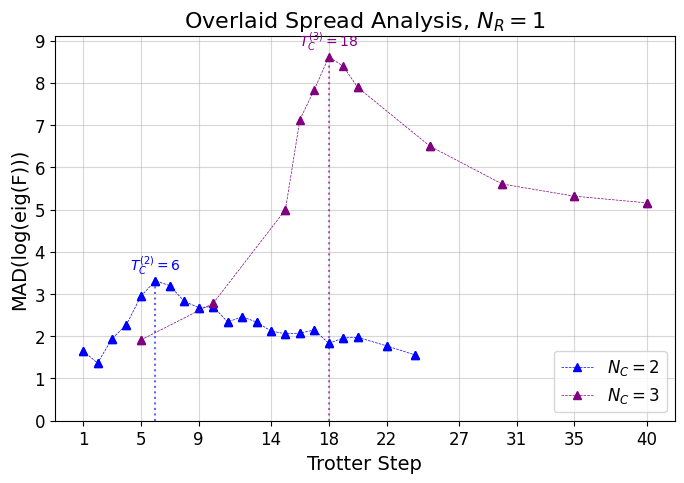

In [106]:
def plot_spread_overlaid_with_TC_for_ctrl(
    df,
    reserv_fixed=1,
    ctrl_list=[1,2,3],
    spread_type="mad",
    combination="sampled",
    scale="normal",
    ax=None,
    title=None,
    xlabel="Trotter Step",
    ylabel=None
):
    """
    Single subplot that overlays multiple lines for distinct N_ctrl values,
    *all* at a fixed N_reserv. Each line shows the chosen spread metric
    (variance or mad), either 'sampled' or 'pooled', with T_C detection.

    We detect each T_C by finding the argmax of the chosen curve for that N_ctrl,
    then annotate it with a vertical line & label: T_C^{(N_ctrl)} = value.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns like 'spread_mean_per_sample_{spread_type}_{scale}',
        'spread_std_per_sample_{spread_type}_{scale}', 'spread_val_pooled_{spread_type}_{scale}',
        plus 'N_ctrl','N_reserv','Trotter_Step'.
    reserv_fixed : int
        The reservoir qubit number to hold constant.
    ctrl_list : list of int
        Which N_ctrl values to overlay.
    spread_type : str
        'variance' or 'mad'.
    combination : str
        'pooled' or 'sampled'.
    scale : str
        Typically 'normal' (to match how your columns are named).
    ax : matplotlib axis
        If None, we create a new figure & axis.
    title : str
        Title of the plot.
    xlabel : str
        X-axis label.
    ylabel : str
        Y-axis label (optional).
    """

    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be either 'pooled' or 'sampled'")
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")

    # Create axis if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    else:
        fig = ax.figure

    # We'll define a color cycle for the lines
    color_cycle = plt.cm.get_cmap('Set1', len(ctrl_list))

    # Column names
    y_mean_col = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_std_col  = f"spread_std_per_sample_{spread_type}_{scale}"
    y_pool_col = f"spread_val_pooled_{spread_type}_{scale}"

    for i, ctrl_val in enumerate(ctrl_list):
        # Filter the DataFrame for this (N_ctrl, N_reserv)
        df_filt = df.query("N_ctrl==@ctrl_val & N_reserv==@reserv_fixed").copy()
        df_filt.sort_values("Trotter_Step", inplace=True)
        if df_filt.empty:
            # If no data for this combination, skip
            continue

        x_vals = df_filt["Trotter_Step"].values
        y_mean = df_filt[y_mean_col].values
        y_std  = df_filt[y_std_col].values
        y_pool = df_filt[y_pool_col].values

        # Decide which y-values to plot
        if combination == "sampled":
            y_plot = y_mean
        else:  # "pooled"
            y_plot = y_pool

        # Plot the line
        color = color_cycle(i)
        ax.plot(x_vals, y_plot, 'o--', color=color, label=fr"$N_C={ctrl_val}$")

        # Identify T_C => peak in y_plot
        peak_idx = int(np.argmax(y_plot))
        peak_T   = x_vals[peak_idx]
        peak_val = y_plot[peak_idx]
        x_ticks = np.linspace(min(x_vals), max(x_vals), num=10, dtype=int)
        x_ticks = np.unique(np.append(x_ticks, [1]))  # Ensure T=1 and T_C are always included
        ax.set_xticks(x_ticks)

        # Annotate T_C with a vertical line + text: T_C^{(ctrl_val)}
        ax.axvline(x=peak_T, color=color, linestyle=':', alpha=0.6)
        ax.text(
            peak_T, peak_val + 0.1,
            fr"$T_C^{{({ctrl_val})}}={peak_T}$", fontsize=10, color=color,
            ha='center', va='bottom'
        )

    # Axis labeling
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12)
    if not title:
        title = f"Overlaid Spread Analysis, $N_R={reserv_fixed}$"
    ax.set_title(title, fontsize=16)

    return ax
fig, ax = plt.subplots(figsize=(8,5))
plot_spread_overlaid_with_TC_for_ctrl(
    df_all, reserv_fixed=1, ctrl_list=[2,3],
    spread_type="mad", combination="sampled", scale="normal", ax=ax
)
plt.show()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

def plot_spread_overlaid_with_TC_for_ctrl(
    df,
    reserv_fixed=1,
    ctrl_list=[2, 3],
    spread_type="mad",
    combination="sampled",
    scale="normal",
    ax=None,
    ctrl_colors=None,
    color_map="tab10",
    title=None,
    xlabel="Trotter Step",
    ylabel=None,
    legend_loc="lower right",
    num_xticks=10
):
    """
    Single subplot that overlays multiple lines for distinct N_ctrl values,
    all at a fixed N_reserv. Each line shows the chosen spread metric
    ('variance' or 'mad'), either 'sampled' or 'pooled', with T_C detection.

    Styling is made to match plot_max_rank_vs_params_overlaid_for_ctrl:
      - Marker '^', dashed line '--', custom color or fallback to a colormap
      - Vertical line at T_C from y=0 to y=peak_value
      - T_C annotation above the peak
      - Legend in 'lower right' by default
      - X-ticks and Y-ticks set similarly

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns for spread data, e.g.:
          'spread_mean_per_sample_{spread_type}_{scale}',
          'spread_std_per_sample_{spread_type}_{scale}',
          'spread_val_pooled_{spread_type}_{scale}',
        plus 'N_ctrl','N_reserv','Trotter_Step'.
    reserv_fixed : int
        Which N_reserv to fix for all lines.
    ctrl_list : list of int
        Which N_ctrl values to overlay.
    spread_type : {'variance','mad'}
        Which spread metric to plot.
    combination : {'pooled','sampled'}
        Whether to plot 'pooled' or 'sampled' data.
    scale : str
        Usually 'normal', matching the suffix in your DataFrame columns.
    ax : matplotlib.axes.Axes or None
        If None, a new figure/axes is created.
    ctrl_colors : dict or None
        Optional mapping {N_ctrl_value: color_str}.
        If None or missing a key, we use a fallback from 'color_map'.
    color_map : str
        Name of the colormap to use if ctrl_colors is missing an entry.
    title : str
        Plot title. If None, a default is generated.
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis. If None, defaults to "MAD(log(eig(F)))" or "VARIANCE(...)"
    legend_loc : str
        Location of the legend.
    num_xticks : int
        Number of x ticks to generate via linspace.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    # Validate inputs
    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be 'pooled' or 'sampled'")
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")

    # Create axis if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # If no custom color dict, create an empty one
    if ctrl_colors is None:
        ctrl_colors = {}

    # Prepare a colormap fallback
    cmap = plt.cm.get_cmap(color_map, len(ctrl_list))

    # Column names
    y_mean_col = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_std_col  = f"spread_std_per_sample_{spread_type}_{scale}"
    y_pool_col = f"spread_val_pooled_{spread_type}_{scale}"

    # We'll track a global max Y for setting the y-limit
    global_max_y = 0.0

    for i, ctrl_val in enumerate(ctrl_list):
        # Filter data for (N_ctrl, N_reserv)
        df_filt = df.query("N_ctrl == @ctrl_val & N_reserv == @reserv_fixed").copy()
        df_filt.sort_values("Trotter_Step", inplace=True)
        if df_filt.empty:
            continue

        x_vals = df_filt["Trotter_Step"].values
        y_mean = df_filt[y_mean_col].values
        y_pool = df_filt[y_pool_col].values

        # Choose which array to plot
        if combination == "sampled":
            y_plot = y_mean
        else:  # "pooled"
            y_plot = y_pool

        # Determine color for this N_ctrl
        c = ctrl_colors.get(ctrl_val, cmap(i))

        # Plot with marker '^' and dashed line, matching style
        ax.plot(
            x_vals,
            y_plot,
            marker='^',
            linestyle='--',
            linewidth=0.5,
            color=c,
            label=fr"$N_C={ctrl_val}$",
            zorder=10
        )

        # Identify T_C => peak in y_plot
        peak_idx = int(np.argmax(y_plot))
        peak_T   = x_vals[peak_idx]
        peak_val = y_plot[peak_idx]

        # Draw a vertical line from y=0 to y=peak_val
        ax.vlines(peak_T, 0, peak_val, color=c, linestyle=':', alpha=0.6)

        # Annotate T_C near the peak
        # (Adjust offset as needed for your data scale)
        ax.text(
            peak_T,
            peak_val + 0.1,
            fr"$T_C^{{({ctrl_val})}}={peak_T}$",
            fontsize=10,
            color=c,
            ha='center',
            va='bottom'
        )

        # Update global max
        local_max = np.max(y_plot)
        if local_max > global_max_y:
            global_max_y = local_max

    # Set x-ticks similarly to your other function
    if len(df) > 0:
        all_t = df.query("N_reserv == @reserv_fixed")["Trotter_Step"].unique()
        t_min, t_max = all_t.min(), all_t.max()
    else:
        t_min, t_max = 1, 1

    x_ticks = np.linspace(t_min, t_max, num=num_xticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1]))  # ensure T=1 included
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)

    # Set Y-axis from 0 up to a bit above global_max_y
    y_margin = 0.5  # small extra space above the max
    top_lim = global_max_y + y_margin
    ax.set_ylim(bottom=0, top=top_lim)

    # You can set integer ticks or a custom spacing if desired
    # For example, if spread values are typically small, you might do step=1
    # We'll pick a step that depends on top_lim
    if top_lim <= 11:
        step = 1
    else:
        step = 2
    y_ticks = np.arange(0, top_lim + step+1, step)
    ax.set_yticks(y_ticks[y_ticks <= top_lim])
    ax.set_yticklabels([str(int(y)) for y in y_ticks if y <= top_lim], fontsize=12)

    # Axis labeling
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)

    # Title & legend
    if not title:
        title = f"Overlaid Spread Analysis, $N_R={reserv_fixed}$"
    ax.set_title(title, fontsize=16)

    ax.legend(loc=legend_loc, fontsize=12)
    ax.grid(True, alpha=0.5)

    return ax


fig, ax = plt.subplots(figsize=(8,5))

# Suppose we want N_C=2 to be 'blue', N_C=3 to be 'purple':
ctrl_colors = {
    2: 'blue',
    3: 'purple'
}

plot_spread_overlaid_with_TC_for_ctrl(
    df_all,
    reserv_fixed=1,
    ctrl_list=[2, 3],
    spread_type="mad",
    combination="sampled",
    scale="normal",
    ax=ax,
    ctrl_colors=ctrl_colors,
    color_map="tab10",
    legend_loc="lower right",
    title="Overlaid Spread Analysis, $N_R=1$"
)
plt.show()


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_20039/1836642305.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap(color_map, len(ctrl_list))


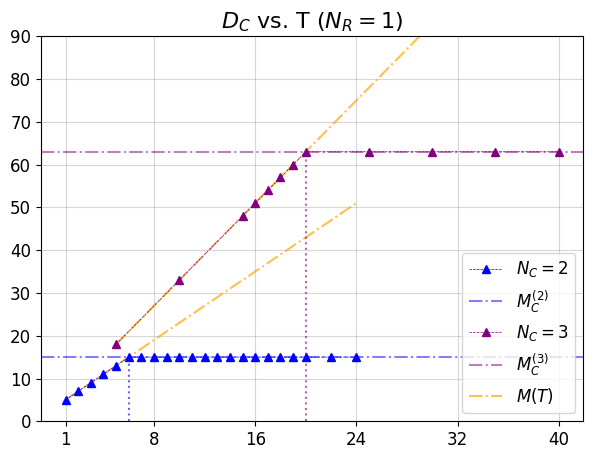

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_20039/1836642305.py:307: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(ctrl_list))


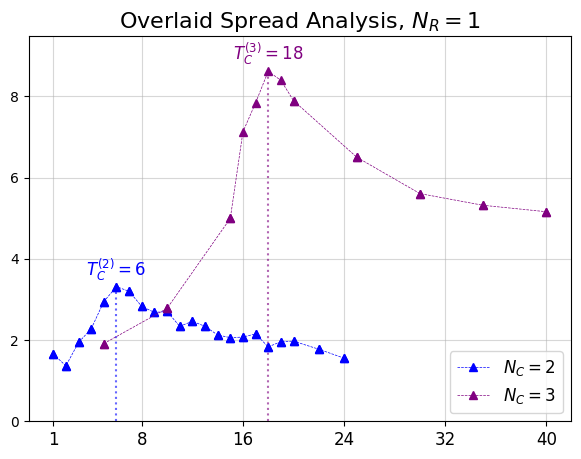

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
def plot_max_rank_vs_params_overlaid_for_ctrl(
    df,
    reserv_fixed=1,
    ctrl_list=[2, 3],
    rank_colors=None,
    xlabel='T',
    ylabel='Parameter Dimension',
    title=None,
    ax=None,
    color_map='tab10',
    legend_loc='lower right',
    num_ticks=6
):
    """
    Single subplot overlaying the 'max rank vs. T' logic for multiple N_ctrl values,
    while N_reserv is fixed (defaults to 1).

    Each N_ctrl gets:
      - A rank-vs-T line with color c
      - M(T) = (N_reserv*N_ctrl*T + 3) line in the same color, with different style
      - A horizontal line at M_C (param dimension at T_C) in that same color
      - A vertical line at T_C with text label T_C^{(N_ctrl)}

    This imitates the full 'plot_max_rank_vs_params' style but for multiple curves in one figure.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'N_ctrl','N_reserv','Trotter_Step','QFIM_ranks'.
    reserv_fixed : int
        N_reserv value to hold constant across all overlaid lines.
    ctrl_list : list of int
        Distinct N_ctrl values we want to overlay in one plot.
    xlabel, ylabel : str
        Axis labels.
    title : str
        Plot title. If None, we autogenerate one.
    color_map : str
        The colormap name to draw distinct colors from, e.g. 'tab10'.
    legend_loc : str
        Where to place the legend.
    num_ticks : int
        Number of x ticks to generate.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if df.empty:
        raise ValueError("DataFrame is empty. Please provide valid data.")

    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    else:
        fig = ax.figure

    # Prepare a color cycle
    cm = plt.cm.get_cmap(color_map, len(ctrl_list))

    # We will gather all T values from all lines for setting x-ticks
    # and keep track of the global max dimension for y-limits
    all_t = set()
    global_max_dim = 0.0  # to store the max of (rank or M(T)) across all lines
    # We only want one legend entry for M(T)
    m_legend_added = False
    for i, ctrl_val in enumerate(ctrl_list):
        # Filter the DataFrame for this N_ctrl
        subset = df.query("N_ctrl == @ctrl_val and N_reserv == @reserv_fixed").copy()
        if subset.empty:
            continue

        # For each Trotter_Step, find the maximum rank
        trotter_steps = []
        max_ranks = []
        for T_step, grp in subset.groupby('Trotter_Step'):
            all_ranks = [rank for row in grp['QFIM_ranks'] for rank in row]
            if all_ranks:
                rmax = np.max(all_ranks)
            else:
                rmax = 0
            trotter_steps.append(T_step)
            max_ranks.append(rmax)

        # Sort them by T
        trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

        # Construct M(T) = N_reserv*N_ctrl*T + 3 (digital model)
        param_list = [reserv_fixed * ctrl_val * t + 3 for t in trotter_steps]

        # Identify T_C => argmax of max_ranks
        idx_C = int(np.argmax(max_ranks))
        T_C   = trotter_steps[idx_C]
        M_C   = param_list[idx_C]
        rankC = max_ranks[idx_C]

        # Determine the color for this rank curve
        c = rank_colors.get(ctrl_val, f"C{ctrl_val}")  # default fallback if not in dict


        # Plot the rank line, labeled with N_ctrl
        ax.plot(
            trotter_steps, max_ranks,
            marker='^', linestyle='--', linewidth=0.5,
            color=c, label=fr"$N_C={ctrl_val}$",
            zorder=10
        )

        

        # 3) Horizontal line at M_C, slightly lighter
        c_h = to_rgba(c)
        # reduce alpha for the horizontal line
        c_h = (c_h[0], c_h[1], c_h[2], 0.5)
        ax.axhline(
            y=M_C,
            color=c_h,
            linestyle='-.',
            linewidth=1.5,
            label=fr"$M_C^{{({ctrl_val})}}$"
        )

        ax.vlines(T_C, 0, M_C, color=c, linestyle=':', alpha=0.6)
        # ax.text(
        #     T_C, rankC + 2,   # position above the rank
        #     fr"$T_C^{{({ctrl_val})}}={T_C}$",
        #     fontsize=10, color=c, ha='center', va='bottom'
        # )

        # Update the global sets
        for t in trotter_steps:
            all_t.add(t)

        # Track largest dimension among rank or param
        local_max_dim = max(np.max(max_ranks), np.max(param_list))
        if local_max_dim > global_max_dim:
            global_max_dim = local_max_dim
        # 2) Plot M(T) in orange, with only one legend entry
        if not m_legend_added:
            ax.plot(
                trotter_steps,
                param_list,
                color='orange',
                linestyle='-.',
                alpha=0.7,
                linewidth=1.5,
                
            )
            m_legend_added = True
        else:
            # no label for subsequent lines
            ax.plot(
                trotter_steps,
                param_list,
                color='orange',
                linestyle='-.',
                alpha=0.7,
                linewidth=1.5,
                label=r"$M(T)$"
            )

    # Now define the x-ticks
    if len(all_t) == 0:
        # no data?
        all_t = {1}
    t_min, t_max = min(all_t), max(all_t)
    x_ticks = np.linspace(t_min, t_max, num=num_ticks, dtype=int)
    # ensure T=1 included
    x_ticks = np.unique(np.append(x_ticks, [1]))
    # set them
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)

    # Y-axis: integer ticks up to global_max_dim
    # We'll step in increments of 5
    ytop = int(global_max_dim + 10)
    steps = np.arange(0, ytop+1, 10)
    ax.set_yticks(steps)
    ax.set_ylim(bottom=0,top=90)
    ax.set_yticklabels([str(int(y)) for y in steps], fontsize=12)

    # Axis labeling
    # ax.set_xlabel(xlabel, fontsize=14)
    # ax.set_ylabel(ylabel, fontsize=14)

    if not title:
        title = fr"Overlaid Max Rank vs. T for $N_R={reserv_fixed}$"
    ax.set_title(title, fontsize=16)
    
    ax.legend(loc=legend_loc, fontsize=12)
    ax.grid(True, alpha=0.5)

    return ax


fig, ax = plt.subplots(figsize=(7, 5))
rank_colors = {
    2: 'blue',
    3: 'purple',
    4: 'green'
}

plot_max_rank_vs_params_overlaid_for_ctrl(
    df_all,
    reserv_fixed=1,
    ctrl_list=[2, 3, 4],
    rank_colors=rank_colors,
    ax=ax,
    xlabel='T',
    ylabel='Parameter Dimension',
    title='$D_C$ vs. T ($N_R=1$)',
)

plt.show()
import numpy as np
import matplotlib.pyplot as plt

def plot_spread_overlaid_with_TC_for_ctrl(
    df,
    reserv_fixed=1,
    ctrl_list=[2, 3],
    spread_type="mad",
    combination="sampled",
    scale="normal",
    ax=None,
    ctrl_colors=None,
    color_map="tab10",
    title=None,
    xlabel="Trotter Step",
    ylabel=None,
    legend_loc="lower right",
    num_xticks=10
):
    """
    Single subplot that overlays multiple lines for distinct N_ctrl values,
    all at a fixed N_reserv. Each line shows the chosen spread metric
    ('variance' or 'mad'), either 'sampled' or 'pooled', with T_C detection.

    Styling is made to match plot_max_rank_vs_params_overlaid_for_ctrl:
      - Marker '^', dashed line '--', custom color or fallback to a colormap
      - Vertical line at T_C from y=0 to y=peak_value
      - T_C annotation above the peak
      - Legend in 'lower right' by default
      - X-ticks set similarly

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns for spread data, e.g.:
          'spread_mean_per_sample_{spread_type}_{scale}',
          'spread_std_per_sample_{spread_type}_{scale}',
          'spread_val_pooled_{spread_type}_{scale}',
        plus 'N_ctrl','N_reserv','Trotter_Step'.
    reserv_fixed : int
        Which N_reserv to fix for all lines.
    ctrl_list : list of int
        Which N_ctrl values to overlay.
    spread_type : {'variance','mad'}
        Which spread metric to plot.
    combination : {'pooled','sampled'}
        Whether to plot 'pooled' or 'sampled' data.
    scale : str
        Usually 'normal', matching the suffix in your DataFrame columns.
    ax : matplotlib.axes.Axes or None
        If None, a new figure/axes is created.
    ctrl_colors : dict or None
        Optional mapping {N_ctrl_value: color_str}.
        If None or missing a key, we use a fallback from 'color_map'.
    color_map : str
        Name of the colormap to use if ctrl_colors is missing an entry.
    title : str
        Plot title. If None, a default is generated.
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis. If None, defaults to "MAD(log(eig(F)))" or "VARIANCE(...)"
    legend_loc : str
        Location of the legend.
    num_xticks : int
        Number of x ticks to generate via linspace.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    # Validate inputs
    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be 'pooled' or 'sampled'")
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")

    # Create axis if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # If no custom color dict, create an empty one
    if ctrl_colors is None:
        ctrl_colors = {}

    # Prepare a colormap fallback
    cmap = plt.cm.get_cmap(color_map, len(ctrl_list))

    # Column names
    y_mean_col = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_pool_col = f"spread_val_pooled_{spread_type}_{scale}"

    # Track the global max Y for setting a suitable y-limit
    global_max_y = 0.0

    for i, ctrl_val in enumerate(ctrl_list):
        # Filter data for (N_ctrl, N_reserv)
        df_filt = df.query("N_ctrl == @ctrl_val & N_reserv == @reserv_fixed").copy()
        df_filt.sort_values("Trotter_Step", inplace=True)
        if df_filt.empty:
            continue

        x_vals = df_filt["Trotter_Step"].values
        y_mean = df_filt[y_mean_col].values
        y_pool = df_filt[y_pool_col].values

        # Choose which array to plot
        if combination == "sampled":
            y_plot = y_mean
        else:  # "pooled"
            y_plot = y_pool

        # Determine color for this N_ctrl
        c = ctrl_colors.get(ctrl_val, cmap(i))

        # Plot with marker '^' and dashed line '--'
        ax.plot(
            x_vals,
            y_plot,
            marker='^',
            linestyle='--',
            linewidth=0.5,
            color=c,
            label=fr"$N_C={ctrl_val}$",
            zorder=10
        )

        # Identify T_C => peak in y_plot
        peak_idx = int(np.argmax(y_plot))
        peak_T   = x_vals[peak_idx]
        peak_val = y_plot[peak_idx]

        # Draw a vertical line from y=0 to y=peak_val
        ax.vlines(peak_T, 0, peak_val, color=c, linestyle=':', alpha=0.6)

        # Annotate T_C near the peak
        ax.text(
            peak_T,
            peak_val + 0.1,  # slight offset
            fr"$T_C^{{({ctrl_val})}}={peak_T}$",
            fontsize=12,
            color=c,
            ha='center',
            va='bottom'
        )

        # Update global max
        local_max = np.max(y_plot)
        if local_max > global_max_y:
            global_max_y = local_max

    # Set x-ticks
    # We gather all Trotter steps for the chosen N_reserv from the entire df
    df_res = df.query("N_reserv == @reserv_fixed")
    if not df_res.empty:
        all_t = df_res["Trotter_Step"].unique()
        t_min, t_max = all_t.min(), all_t.max()
    else:
        t_min, t_max = 1, 1
    t_min, t_max = min(all_t), max(all_t)
    x_ticks = np.linspace(t_min, t_max, num=6, dtype=int)
    # ensure T=1 included
    x_ticks = np.unique(np.append(x_ticks, [1]))
    # set them
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)
    # x_ticks = np.linspace(t_min, t_max, num=num_xticks, dtype=int)
    # x_ticks = np.unique(np.append(x_ticks, [1]))  # ensure T=1 included
    # ax.set_xticks(x_ticks)
    # ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)

    # Let matplotlib auto-handle y-ticks; just set an upper limit with some margin
    # so we don't clip the peak annotation
    if global_max_y <= 0:
        # fallback if no data
        global_max_y = 1.0
    margin_factor = 1.1
    ax.set_ylim(bottom=0, top=global_max_y * margin_factor)

    # Axis labeling
    # ax.set_xlabel(xlabel, fontsize=14)
    # ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)

    # Title & legend
    if not title:
        title = f"Overlaid Spread Analysis, $N_R={reserv_fixed}$"
    ax.set_title(title, fontsize=16)

    ax.legend(loc=legend_loc, fontsize=12)
    ax.grid(True, alpha=0.5)

    return ax

fig, ax = plt.subplots(figsize=(7,5))

# Suppose we want N_C=2 to be 'blue', N_C=3 to be 'purple':
ctrl_colors = {
    2: 'blue',
    3: 'purple'
}

plot_spread_overlaid_with_TC_for_ctrl(
    df_all,
    reserv_fixed=1,
    ctrl_list=[2, 3],
    spread_type="mad",
    combination="sampled",
    scale="normal",
    ax=ax,
    ctrl_colors=ctrl_colors,
    color_map="tab10",
    legend_loc="lower right",
    title="Overlaid Spread Analysis, $N_R=1$"
)
plt.show()


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_20039/2608579676.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap(color_map, len(ctrl_list))


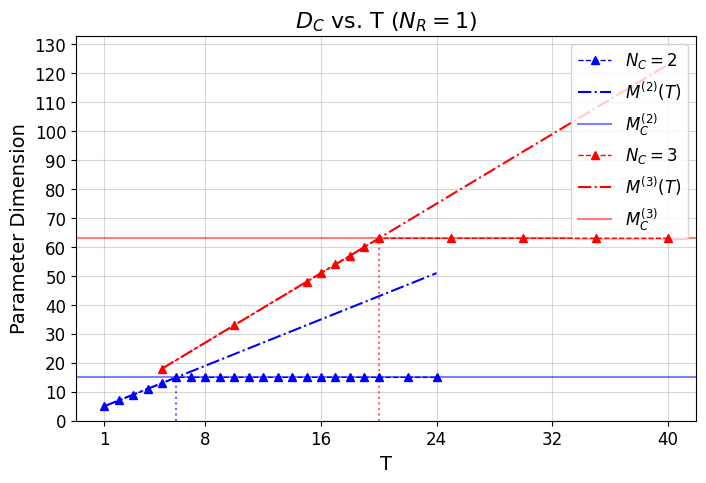

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

def plot_max_rank_vs_params_overlaid_for_ctrl(
    df,
    reserv_fixed=1,
    ctrl_list=[2, 3],
    rank_colors=None,
    xlabel='T',
    ylabel='Parameter Dimension',
    title=None,
    ax=None,
    color_map='tab10',
    legend_loc='upper right',
    num_ticks=6
):
    """
    Single subplot overlaying the 'max rank vs. T' logic for multiple N_ctrl values,
    while N_reserv is fixed (defaults to 1).

    Each N_ctrl gets:
      - A rank-vs-T line (color c, with marker '^')
      - M(T) = (N_reserv*N_ctrl*T + 3) line in the same color (dash-dot),
        labeled "M^{(ctrl_val)}(T)"
      - A horizontal line at M_C (param dimension at T_C) in a lighter alpha
        version of the same color, labeled "M_C^{(ctrl_val)}"
      - A vertical line at T_C (dotted) from y=0 to y=M_C

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'N_ctrl','N_reserv','Trotter_Step','QFIM_ranks'.
    reserv_fixed : int
        N_reserv value to hold constant across all overlaid lines.
    ctrl_list : list of int
        Distinct N_ctrl values we want to overlay in one plot.
    rank_colors : dict or None
        Optional mapping {N_ctrl_value: color_str}.
        If None or missing a key, we use a default color cycle.
    xlabel, ylabel : str
        Axis labels.
    title : str
        Plot title. If None, we autogenerate one.
    ax : matplotlib.axes.Axes or None
        If None, a new figure/axes is created.
    color_map : str
        The colormap name (used only if rank_colors does not provide a color).
    legend_loc : str
        Where to place the legend.
    num_ticks : int
        Number of x ticks to generate.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if df.empty:
        raise ValueError("DataFrame is empty. Please provide valid data.")

    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    else:
        fig = ax.figure

    # If no custom colors provided, we'll fall back to colormap
    if rank_colors is None:
        rank_colors = {}

    cm = plt.cm.get_cmap(color_map, len(ctrl_list))

    all_t = set()
    global_max_dim = 0.0

    for i, ctrl_val in enumerate(ctrl_list):
        subset = df.query("N_ctrl == @ctrl_val and N_reserv == @reserv_fixed").copy()
        if subset.empty:
            continue

        # Gather max rank per T
        trotter_steps = []
        max_ranks = []
        for T_step, grp in subset.groupby('Trotter_Step'):
            all_ranks = [r for row in grp['QFIM_ranks'] for r in row]
            rmax = np.max(all_ranks) if all_ranks else 0
            trotter_steps.append(T_step)
            max_ranks.append(rmax)

        # Sort by T
        trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

        # M(T) = N_reserv*N_ctrl*T + 3
        param_list = [reserv_fixed * ctrl_val * t + 3 for t in trotter_steps]

        # Identify T_C => argmax of max_ranks
        idx_C = int(np.argmax(max_ranks))
        T_C   = trotter_steps[idx_C]
        M_C   = param_list[idx_C]

        # Determine color for this N_ctrl
        if ctrl_val in rank_colors:
            c = rank_colors[ctrl_val]
        else:
            # fallback: use color from colormap
            c = cm(i)

        # 1) Plot max-rank line
        ax.plot(
            trotter_steps,
            max_ranks,
            marker='^', linestyle='--',
            linewidth=1,
            color=c,
            label=fr"$N_C={ctrl_val}$",
            zorder=10
        )

        # 2) Plot M(T) in the same color (dash-dot)
        ax.plot(
            trotter_steps,
            param_list,
            color=c,
            linestyle='-.',
            linewidth=1.5,
            label=fr"$M^{{({ctrl_val})}}(T)$"
        )

        # 3) Horizontal line at M_C, slightly lighter
        c_h = to_rgba(c)
        # reduce alpha for the horizontal line
        c_h = (c_h[0], c_h[1], c_h[2], 0.5)
        ax.axhline(
            y=M_C,
            color=c_h,
            linestyle='-',
            linewidth=1.5,
            label=fr"$M_C^{{({ctrl_val})}}$"
        )

        # 4) Vertical line at T_C from y=0 to y=M_C
        ax.vlines(
            T_C,
            0, M_C,
            color=c,
            linestyle=':',
            alpha=0.6
        )

        # Update sets and dimension tracking
        for t in trotter_steps:
            all_t.add(t)

        local_max_dim = max(np.max(max_ranks), np.max(param_list))
        if local_max_dim > global_max_dim:
            global_max_dim = local_max_dim

    # X-ticks
    if not all_t:
        all_t = {1}
    t_min, t_max = min(all_t), max(all_t)
    x_ticks = np.linspace(t_min, t_max, num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1]))  # ensure T=1 included
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)

    # Y-ticks in increments of 10, from 0 to a bit above global max
    ytop = int(global_max_dim + 10)
    steps = np.arange(0, ytop + 1, 10)
    ax.set_yticks(steps)
    ax.set_ylim(bottom=0, top=ytop)
    ax.set_yticklabels([str(int(y)) for y in steps], fontsize=12)

    # Axis labels
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    if not title:
        title = fr"Overlaid Max Rank vs. T for $N_R={reserv_fixed}$"
    ax.set_title(title, fontsize=16)

    ax.legend(loc=legend_loc, fontsize=12)
    ax.grid(True, alpha=0.5)

    return ax


fig, ax = plt.subplots(figsize=(8, 5))
rank_colors = {
    2: 'blue',
    3: 'red',
    4: 'green'
}

plot_max_rank_vs_params_overlaid_for_ctrl(
    df_all,
    reserv_fixed=1,
    ctrl_list=[2, 3, 4],
    rank_colors=rank_colors,
    ax=ax,
    xlabel='T',
    ylabel='Parameter Dimension',
    title='$D_C$ vs. T ($N_R=1$)',
)

plt.show()



Detected critical T_C = 6
Peak at T [Mad(log(normed eigvals)), sampled] = 6
Detected critical T_C = 3
Peak at T [Mad(log(normed eigvals)), sampled] = 3
Detected critical T_C = 2
Peak at T [Mad(log(normed eigvals)), sampled] = 2


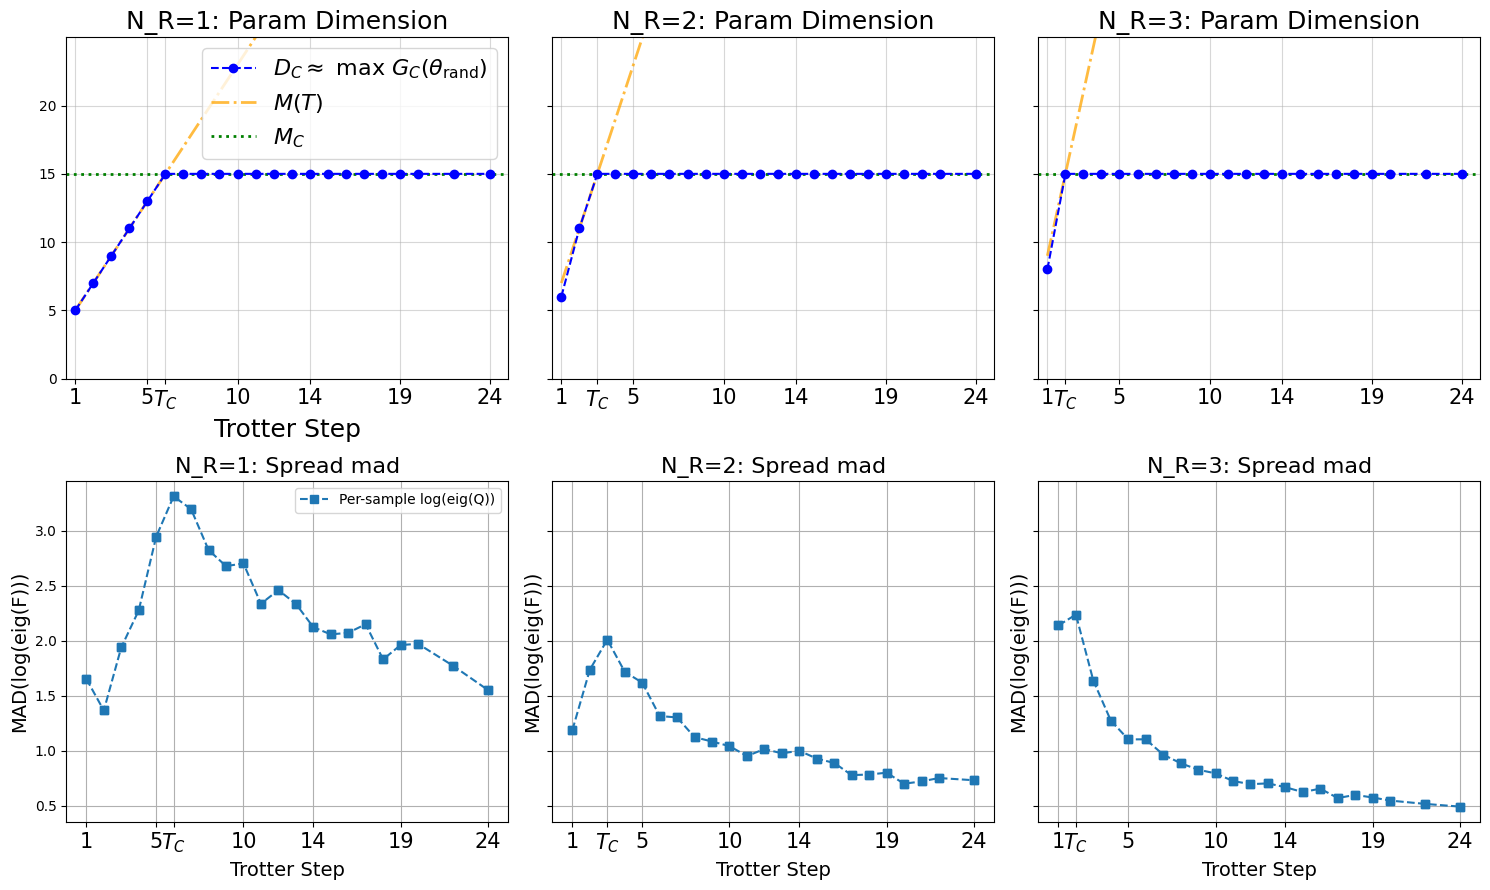

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_many_reserv_shared_y(df, N_ctrl=2, reserv_list=[1, 2, 3], spread_type="mad"):
    """
    Creates a 2xN grid of subplots, with the top row showing plot_max_rank_vs_params
    and the bottom row showing plot_spread_analysis. Each column is a different N_R.
    
    This version uses a single shared y-axis label for the top row 
    and a single shared y-axis label for the bottom row.
    """

    ncols = len(reserv_list)
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(5*ncols, 9),
                             sharex=False, sharey='row')
    # 'sharey=row' means each row shares a y-axis among its columns.

    # If there's only 1 column, axes might not be 2D, so ensure we treat it properly
    if ncols == 1:
        axes = np.array([axes]).T  # shape => (2,1)

    # 1) Top row label: set on the leftmost subplot
    axes[0,0].set_ylabel("Parameter Dimension", fontsize=12)

    # 2) Bottom row label: similarly on the leftmost subplot
    axes[1,0].set_ylabel("Spread of log(eig(F))", fontsize=12)

    for col_idx, nr_val in enumerate(reserv_list):
        # ------------------------------------------------
        # Top row: param dimension vs. T
        # ------------------------------------------------
        ax_top = axes[0, col_idx]
        plot_max_rank_vs_params(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val, ax=ax_top,
            xlabel="Trotter Step" if col_idx == 0 else "", # maybe keep or remove 
            ylabel=None,  # We'll rely on the shared row label
            title=f"N_R={nr_val}: Param Dimension"
        )
        # Optionally remove repeated legends from columns > 0
        if col_idx > 0 and ax_top.get_legend():
            ax_top.get_legend().remove()

        # ------------------------------------------------
        # Bottom row: spread analysis
        # ------------------------------------------------
        ax_bot = axes[1, col_idx]
        plot_spread_analysis(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val,
            ax=ax_bot, spread_type=spread_type, combination="sampled",
            xlabel="Trotter Step", ylabel=None,
            title=f"N_R={nr_val}: Spread {spread_type}"
        )

        if col_idx > 0 and ax_bot.get_legend():
            ax_bot.get_legend().remove()

    plt.tight_layout()
    return fig, axes

# Example usage:
fig, axes = plot_many_reserv_shared_y(df_all, N_ctrl=2, reserv_list=[1,2,3], spread_type="mad")
# plt.show()

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_20039/3113285495.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_cycle = plt.cm.get_cmap('tab10', len(reserv_list))


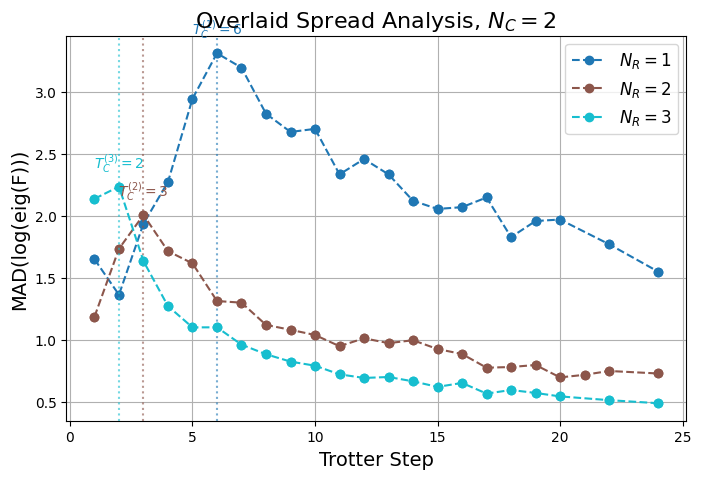

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spread_overlaid_with_TC(
    df,
    N_ctrl=2,
    reserv_list=[1,2,3],
    spread_type="mad",
    combination="sampled",
    scale="normal",
    ax=None,
    title=None,
    xlabel="Trotter Step",
    ylabel=None
):
    """
    Single subplot that overlays multiple lines for each N_reserv,
    showing the spread_of_log metric from your DataFrame.
    
    We also detect each T_C by finding the argmax of the chosen curve 
    and annotate it with a vertical line & label: T_C^{(N_R=2)}.
    
    Parameters:
      - df: your main DataFrame with columns like spread_mean_per_sample_{spread_type}_{scale}
      - N_ctrl: the control qubit number
      - reserv_list: which reservoir values to overplot
      - spread_type: 'variance' or 'mad'
      - combination: 'pooled' or 'sampled'
      - scale: typically 'normal'
      - ax: optional matplotlib axis
      - title: figure title
      - xlabel, ylabel: axis labels
    """

    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be either 'pooled' or 'sampled'")
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")

    # Create axis if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    else:
        fig = ax.figure

    # We'll define a color cycle for the lines
    color_cycle = plt.cm.get_cmap('tab10', len(reserv_list))

    # Column names
    y_mean_col = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_std_col  = f"spread_std_per_sample_{spread_type}_{scale}"
    y_pool_col = f"spread_val_pooled_{spread_type}_{scale}"

    for i, nr_val in enumerate(reserv_list):
        df_filt = df.query("N_ctrl==@N_ctrl & N_reserv==@nr_val").copy()
        df_filt.sort_values("Trotter_Step", inplace=True)
        x_vals = df_filt["Trotter_Step"].values

        y_mean = df_filt[y_mean_col].values
        y_std  = df_filt[y_std_col].values
        y_pool = df_filt[y_pool_col].values

        # Decide which y-values to plot
        if combination == "sampled":
            y_plot = y_mean
        else:
            y_plot = y_pool

        # Plot the line
        color = color_cycle(i)
        ax.plot(x_vals, y_plot, 'o--', color=color, label=fr"$N_R={nr_val}$")

        # 1) Identify T_C => peak in y_plot
        peak_idx = int(np.argmax(y_plot))
        peak_T   = x_vals[peak_idx]
        peak_val = y_plot[peak_idx]

        # 2) Annotate T_C with a vertical line or text
        # We'll do a vertical line plus a small text
        # e.g. T_C^{(2)} near the top
        ax.axvline(x=peak_T, color=color, linestyle=':', alpha=0.6)
        ax.text(
            peak_T, peak_val + 0.1,   # position slightly above the peak
            fr"$T_C^{{({nr_val})}}={peak_T}$", fontsize=10, color=color,
            ha='center', va='bottom'
        )

    # Axis labeling
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12)
    if not title:
        title = f"Overlaid Spread Analysis, $N_C={N_ctrl}$"
    ax.set_title(title, fontsize=16)
    return ax

# Example usage:

fig, ax = plt.subplots(figsize=(8,5))
plot_spread_overlaid_with_TC(
    df_all, N_ctrl=2, reserv_list=[1,2,3], spread_type="mad",
    combination="sampled", scale="normal", ax=ax
)
plt.show()


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_20039/3356572424.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.0f}")


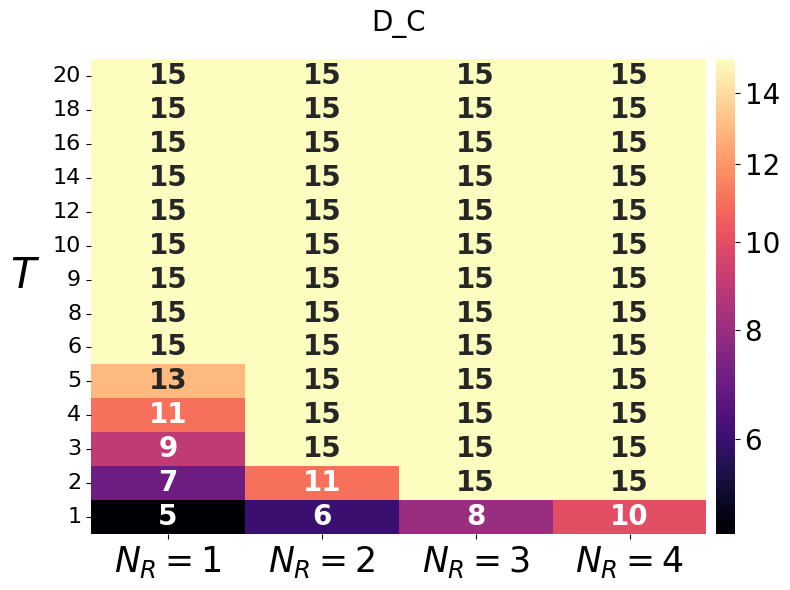

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_20039/3356572424.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


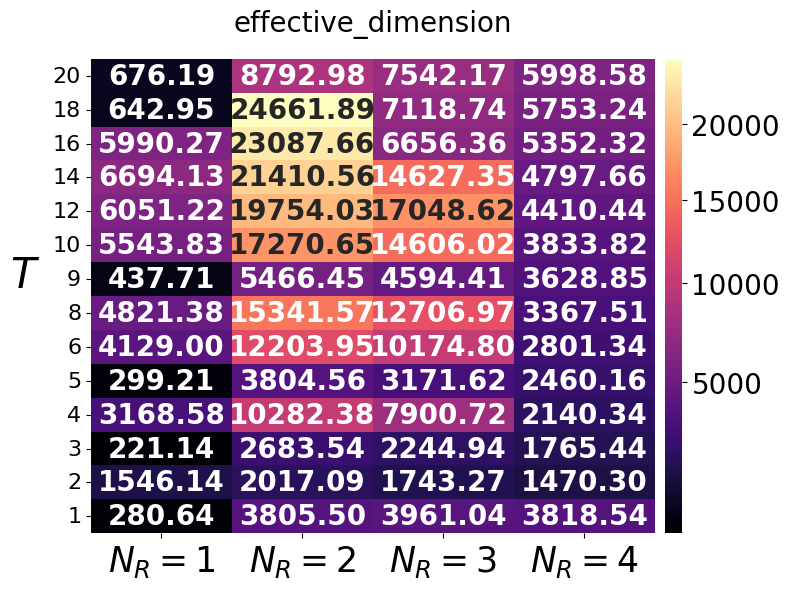

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_20039/3356572424.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


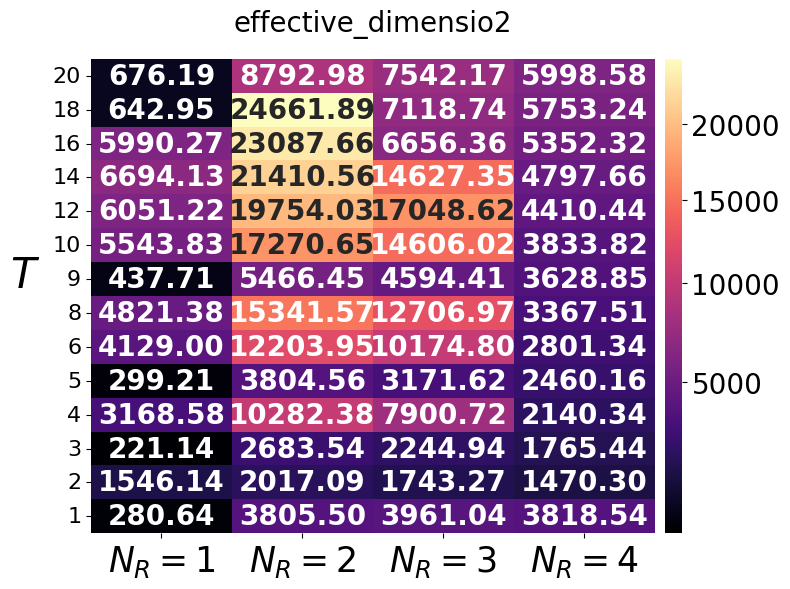

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_20039/3356572424.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


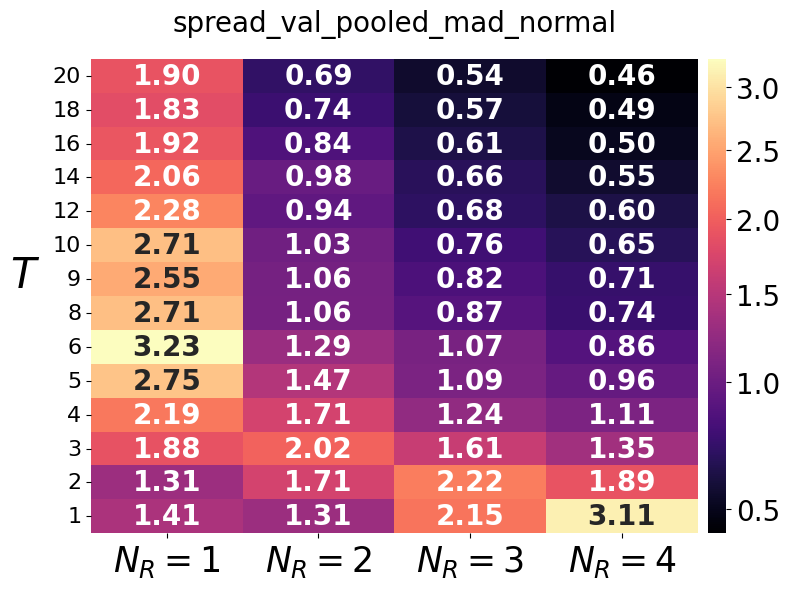

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm

N_ctrl = chosen_n_ctrl
def plot_qfim_metrics_heatmaps(df_all, N_ctrl, metric_keys, metrics_info, resies=None):
    """
    Generates heatmaps for multiple metrics specified in 'metric_keys' 
    using the definitions/titles in 'metrics_info'.

    - df_all: your main DataFrame.
    - N_ctrl: the control-qubit dimension you're focusing on (int).
    - metric_keys: list of column names in df_all that you want to plot.
    - metrics_info: dict with metadata for each metric_key, e.g.:
        metrics_info = {
            'mean_trace_eigvals': {
                'title': 'Mean Trace of QFIM',
                'cbar': ''
            },
            ...
        }
    - resies: list of reservoir-qubit counts you want on the x-axis 
      (defaults to [1,2,3,4] or whatever you specify).
    """

    # 1) Default reservoir list if none provided
    if resies is None:
        resies = [1, 2, 3]

    # 2) Decide how to pick Trotter steps based on N_ctrl
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6]
    elif N_ctrl == 3:
        trots = np.arange(1, 60, 1)  # or your preferred range
    else:
        trots = [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 16, 18, 20]

    # 3) Single filter step for this N_ctrl, reservoir set, and Trotter steps
    df_filtered = df_all.query("N_ctrl == @N_ctrl").copy()
    df_filtered = df_filtered[df_filtered["N_reserv"].isin(resies)]
    df_filtered = df_filtered[df_filtered["Trotter_Step"].isin(trots)]

    # 4) Loop over each metric you want to plot
    for metric_key in metric_keys:
        if metric_key not in df_filtered.columns:
            print(f"Warning: '{metric_key}' not in df_filtered columns.")
            continue

        # Retrieve title & color bar label from your dictionary
        metric_title = metric_key
        metric_cbar=''
        # metric_title = metrics_info.get(metric_key, {}).get('title', metric_key)
        # metric_cbar  = metrics_info.get(metric_key, {}).get('cbar', '')

        # 4a) Pivot the data for a heatmap
        df_heatmap = (
            df_filtered[["N_reserv", "Trotter_Step", metric_key]]
            .groupby(["Trotter_Step", "N_reserv"])[metric_key]
            .mean()  # or .median(), .max() etc. if desired
            .reset_index()
        )
        heatmap_pivot = df_heatmap.pivot(index="Trotter_Step", columns="N_reserv", values=metric_key)

        # 4b) Compute min/max for color normalization
        min_val = heatmap_pivot.min().min()
        max_val = heatmap_pivot.max().max()

        # 4c) Create formatted annotations
        # D_C: integer ranks, so show 0 decimal places
        if metric_key == "D_C":
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.0f}")
        else:
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")

        # 5) Plotting
        fig, ax = plt.subplots(figsize=(8, 6))

        # Create a divider to place colorbar alongside the heatmap
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)

        # Example: use a power-law normalization
        sns.heatmap(
            heatmap_pivot,
            annot=annotation_matrix, fmt="",  # fmt="" so we use our own annotated strings
            ax=ax, cbar_ax=cax, cmap="magma",
            annot_kws={"weight": "bold", "size": 20},
            norm=PowerNorm(gamma=0.7, vmin=min_val, vmax=max_val)
        )

        # Invert y-axis so T=1 is at the top
        ax.invert_yaxis()

        # Configure colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)

        # Title & labels
        ax.set_title(metric_title, fontsize=20, pad=20)
        ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
        ax.set_xlabel("", fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=16)
        ax.tick_params(axis='x', labelsize=16)

        # Format x-tick labels
        xticklabels = [f'$N_R = {int(col)}$' for col in heatmap_pivot.columns]
        ax.set_xticklabels(xticklabels, fontweight="bold", fontsize=25, rotation=0)

        plt.tight_layout()
        plt.show()

metric_keys = ['D_C',"effective_dimension","effective_dimensio2","spread_val_pooled_mad_normal",'d_eff_ipr']
# metric_keys = ['spread_val_pooled_mad_normal','spread_val_pooled_mad']
# metric_keys = ['D_C','d_eff_ipr']

plot_qfim_metrics_heatmaps(df_all, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info={}, resies=[1,2,3,4])

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_97366/89122168.py:313: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


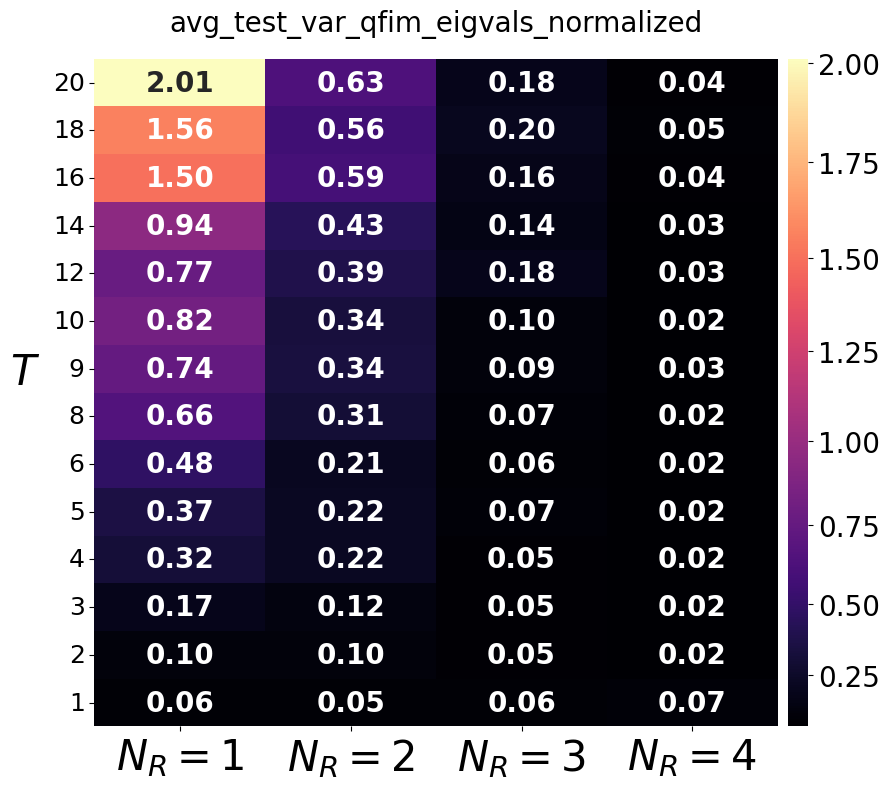

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_97366/89122168.py:313: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


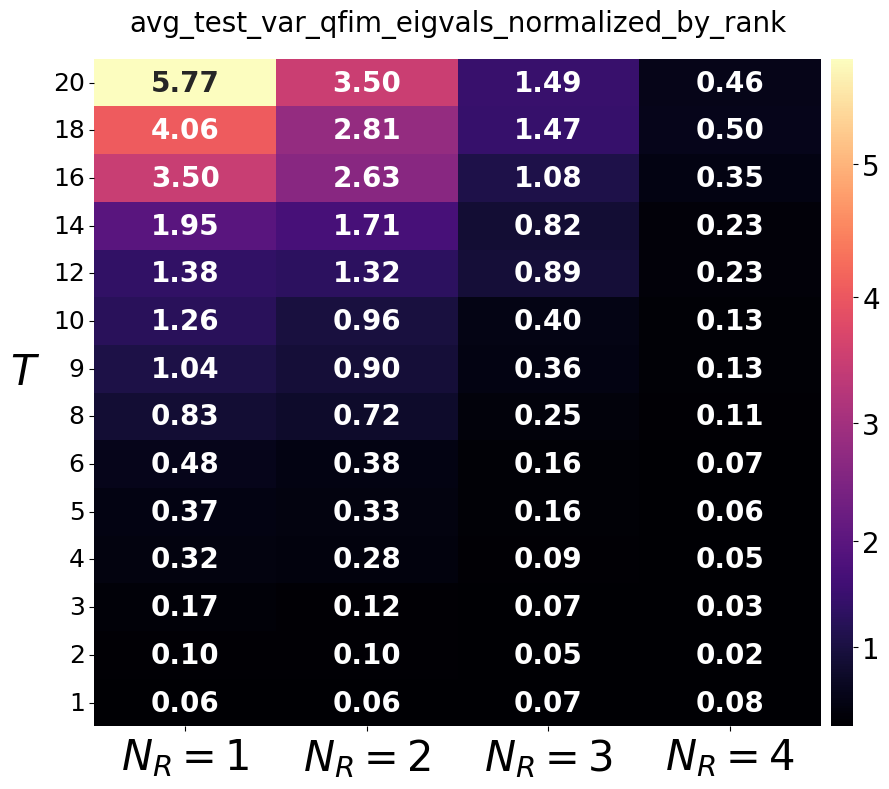

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_97366/89122168.py:313: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


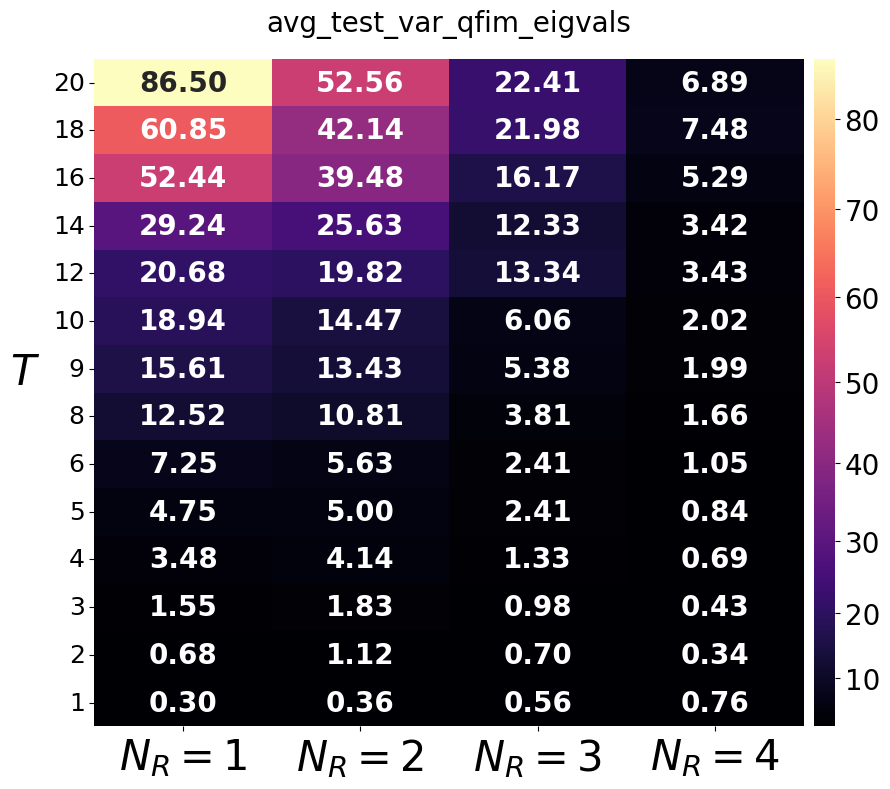

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_97366/89122168.py:313: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


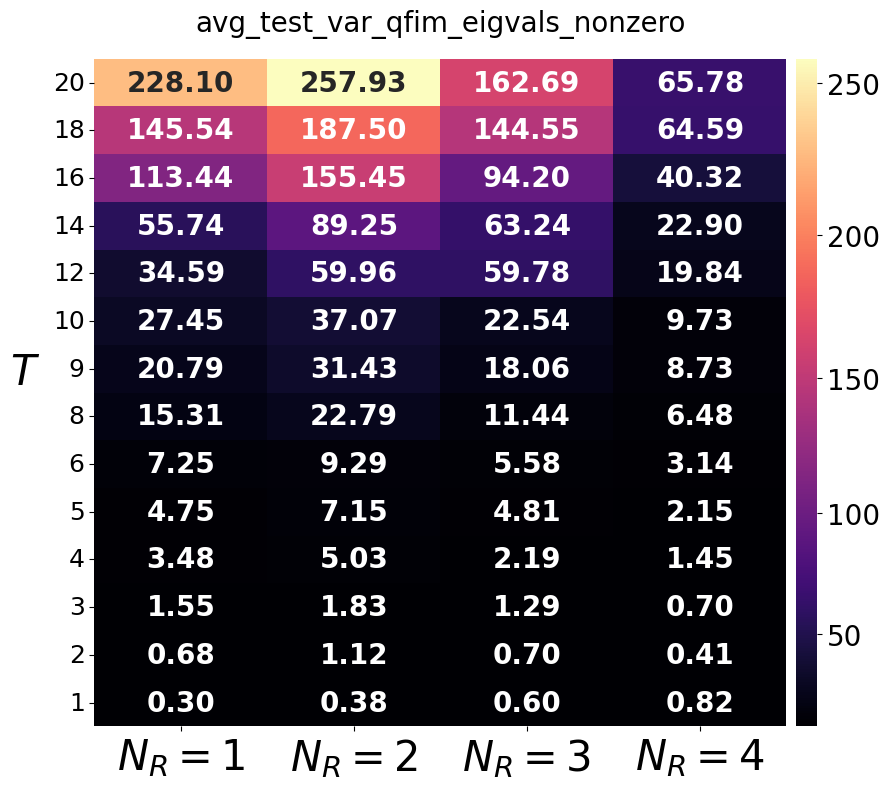

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
chosen_n_ctrl=2
N_ctrls = [2,3]
N_ctrl = chosen_n_ctrl
metrics_info ={
    'avg_test_tr_qfim_eigvals_norm_by_rank': {
        'title': f'Sum($\lambda_Q$)/ $G_C$ [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_ipr_dim': {
        'title': f'Mean IPR Dimension [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_normalized': {
        'title': f'Mean Var($\lambda_Q$) Normalized [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_nonzero_normalized_by_rank': {
        'title': f'Var($\lambda_Q$) Normalized by Quantum Dimension [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_tr_qfim_eigvals_norm': {
        'title': f'Normalized Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'D_C': {
        'title': f'Parameter Dimension $D_C$ [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    # Entropy
    'mean_entropy': {
        'title': f'Mean Von Neumann Entropy [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'entropy': {
        'title': f'Von Neumann Entropy Distribution [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Condition Numbers
    'mean(cond_nums)': {
        'title': f'Mean Condition Number of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'cond_nums': {
        'title': f'Condition Numbers of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
}
metrics_info = {
    # Trace Metrics
    'mean_trace_eigvals': {
        'title': f'Mean Trace of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_ipr_dim': {
        'title': f'Mean IPR Dimension [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_tr_qfim_eigvals': {
        'title': f'Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_tr_qfim_eigvals_norm': {
        'title': f'Normalized Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_tr_qfim_eigvals_norm_by_rank': {
        'title': f'Normalized (R) Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'median_trace_eigvals': {
        'title': f'Median Trace of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_trace_eigvals': {
        'title': f'IQR of Trace(QFIM) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_trace_eigvals': {
        'title': f'Weighted Average of Trace(QFIM) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Variance of Eigenvalues
    'mean_var_eigval': {
        'title': f'Mean Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
     'avg_test_var_qfim_eigvals_nonzero': {
        'title': f'Mean Variance of QFIM Eigenvalues (nonzero) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_normalized': {
        'title': f'Mean Variance of QFIM Eigenvalues (normalized) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_nonzero_normalized_by_rank': {
        'title': f'Mean Variance of QFIM Eigenvalues (normalized by rank) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_normalized_by_rank': {
        'title': f'Mean Variance of QFIM Eigenvalues (normalized by R) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_test_var_qfim_eigvals_nonzero': {
        'title': f'log Var(Variance of QFIM) over tsts (nonzero) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals': {
        'title': f'Avg(Variance of QFIM) over tsts [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'median_var_eigval': {
        'title': f'Median Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_var_eigval': {
        'title': f'IQR of Variance(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_var_eigval': {
        'title': f'Weighted Average Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'normalized_var_qfim_eigvals': {
        'title': f'Normalized Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_test_var_qfim_eigvals': {
        'title': f'Var(Variance of QFIM) over tsts  [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_test_var_qfim_eigvals_log': {
        'title': f'log(Var(Variance of QFIM)) over tsts  [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    # Variance of Log-Scaled Eigenvalues
    'mean_var_log_eigval': {
        'title': f'Mean Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'median_var_log_eigval': {
        'title': f'Median Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_var_log_eigval': {
        'title': f'IQR of Variance(log(QFIM Eigenvalues)) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_var_log_eigval': {
        'title': f'Weighted Average Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Entropy
    'mean_entropy': {
        'title': f'Mean Von Neumann Entropy [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'entropy': {
        'title': f'Von Neumann Entropy Distribution [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Condition Numbers
    'mean(cond_nums)': {
        'title': f'Mean Condition Number of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'cond_nums': {
        'title': f'Condition Numbers of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Eigenvalue Metrics
    'max_eigvals': {
        'title': f'Maximum QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'min_eigvals': {
        'title': f'Minimum QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Ratios and Redundancies
    'ratios': {
        'title': f'Ratio of Non-Zero Eigenvalues to Parameters [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'redundancies': {
        'title': f'Redundancy ($G_C$)[$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'global_redundancies': {
        'title': f'Global Redundancy ($R$) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Quantum Dimension
    'quantum_dim': {
        'title': f'Quantum Dimension $G_C$ (Rank) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'D_C': {
        'title': f'Parameter Dimension $D_C$ [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'effective params': {
        'title': f'Effective Parameters [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    # Normalized Trace
    'mean_norm_trace_eigvals': {
        'title': f'Mean Normalized Trace of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Power-Scaled Metrics
    'var_power_scaled_avg_qfim_eigvals': {
        'title': f'Power-Scaled Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_power_scaled_avg_qfim_eigvals_nonzero': {
        'title': f'Power-Scaled Variance of Non-Zero QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Variance of Log Scaled Metrics
    'var_log_qfim_eigvals_nonzero': {
        'title': f'Variance of log(QFIM Eigenvalues) Non-Zero [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Trace Values Direct
    'trace_eigvals': {
        'title': f'Trace of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    }
}
def plot_qfim_metrics_heatmaps(df_all, N_ctrl, metric_keys, metrics_info, resies=None):
    """
    Generates heatmaps for multiple metrics specified in 'metric_keys' 
    using the definitions/titles in 'metrics_info'.

    - df_all: your main DataFrame.
    - N_ctrl: the control-qubit dimension you're focusing on (int).
    - metric_keys: list of column names in df_all that you want to plot.
    - metrics_info: dict with metadata for each metric_key, e.g.:
        metrics_info = {
            'mean_trace_eigvals': {
                'title': 'Mean Trace of QFIM',
                'cbar': ''
            },
            ...
        }
    - resies: list of reservoir-qubit counts you want on the x-axis 
      (defaults to [1,2,3,4] or whatever you specify).
    """

    # 1) Default reservoir list if none provided
    if resies is None:
        resies = [1, 2, 3, 4]

    # 2) Decide how to pick Trotter steps based on N_ctrl
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6]
    elif N_ctrl == 3:
        trots = np.arange(1, 60, 1)  # or your preferred range
    else:
        trots = [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 16, 18, 20]

    # 3) Single filter step for this N_ctrl, reservoir set, and Trotter steps
    df_filtered = df_all.query("N_ctrl == @N_ctrl").copy()
    df_filtered = df_filtered[df_filtered["N_reserv"].isin(resies)]
    df_filtered = df_filtered[df_filtered["Trotter_Step"].isin(trots)]

    # 4) Loop over each metric you want to plot
    for metric_key in metric_keys:
        if metric_key not in df_filtered.columns:
            print(f"Warning: '{metric_key}' not in df_filtered columns.")
            continue

        # Retrieve title & color bar label from your dictionary
        metric_title = metric_key
        metric_cbar=''
        # metric_title = metrics_info.get(metric_key, {}).get('title', metric_key)
        # metric_cbar  = metrics_info.get(metric_key, {}).get('cbar', '')

        # 4a) Pivot the data for a heatmap
        df_heatmap = (
            df_filtered[["N_reserv", "Trotter_Step", metric_key]]
            .groupby(["Trotter_Step", "N_reserv"])[metric_key]
            .mean()  # or .median(), .max() etc. if desired
            .reset_index()
        )
        heatmap_pivot = df_heatmap.pivot(index="Trotter_Step", columns="N_reserv", values=metric_key)

        # 4b) Compute min/max for color normalization
        min_val = heatmap_pivot.min().min()
        max_val = heatmap_pivot.max().max()

        # 4c) Create formatted annotations
        # D_C: integer ranks, so show 0 decimal places
        if metric_key == "D_C":
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.0f}")
        else:
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")

        # 5) Plotting
        fig, ax = plt.subplots(figsize=(9, 8))

        # Create a divider to place colorbar alongside the heatmap
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)

        # Example: use a power-law normalization
        sns.heatmap(
            heatmap_pivot,
            annot=annotation_matrix, fmt="",  # fmt="" so we use our own annotated strings
            ax=ax, cbar_ax=cax, cmap="magma",
            annot_kws={"weight": "bold", "size": 20},
            norm=PowerNorm(gamma=1.2, vmin=min_val, vmax=max_val)
        )

        # Invert y-axis so T=1 is at the top
        ax.invert_yaxis()

        # Configure colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)

        # Title & labels
        ax.set_title(metric_title, fontsize=20, pad=20)
        ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
        ax.set_xlabel("", fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=18)
        ax.tick_params(axis='x', labelsize=18)

        # Format x-tick labels
        xticklabels = [f'$N_R = {int(col)}$' for col in heatmap_pivot.columns]
        ax.set_xticklabels(xticklabels, fontweight="bold", fontsize=30, rotation=0)

        plt.tight_layout()
        plt.show()


# -----------------------
# Example usage in a notebook:
# -----------------------
# metrics_info = {... your big dictionary as in your question ...}
# metric_keys = list(metrics_info.keys())
metric_keys = ['avg_test_var_qfim_eigvals_normalized', 'avg_test_var_qfim_eigvals_nonzero_normalized_by_rank','avg_test_var_qfim_eigvals_nonzero']
metric_keys = ['avg_test_var_qfim_eigvals_normalized','avg_test_var_qfim_eigvals_normalized_by_rank','avg_test_var_qfim_eigvals','avg_test_var_qfim_eigvals_nonzero']
plot_qfim_metrics_heatmaps(df_all, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])